# Analyze substrate solvation

This notebook demonstrates deposition of an SDS adsorption layer on a non-spherical AFM tip model.

## Initialization

### IPython magic

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



### Imports

In [2]:
import ase.io # here used for reading pdb files
from ase.visualize import view
from ase.visualize.plot import plot_atoms # has nasty offset issues
from cycler import cycler # here used for cycling through colors in plots
import datetime
import fabric # for pythonic ssh connections
from fireworks import LaunchPad, Firework, Tracker, Workflow 
from fireworks import FileTransferTask, PyTask, ScriptTask

# FireWorks functionality 
from fireworks import Firework, LaunchPad, ScriptTask, Workflow
from fireworks.user_objects.firetasks.templatewriter_task import TemplateWriterTask
from fireworks.user_objects.firetasks.filepad_tasks import AddFilesTask, GetFilesTask, GetFilesByQueryTask
from imteksimfw.fireworks.user_objects.firetasks.cmd_tasks import CmdTask
from fireworks.utilities.filepad import FilePad # direct FilePad access, similar to the familiar LaunchPad

from collections.abc import Iterable
import glob
import gc # manually clean up memory with gc.collect()
import gromacs # GromacsWrapper, here used for evoking gmc commands, reading and writing .ndx files
# from io import StringIO, TextIOWrapper
import io
from IPython.display import display, Image #, Video # display image files within notebook
from ipywidgets import Video  # display video within notebook
import itertools # for products of iterables
import json # generic serialization of lists and dicts
import jinja2 # here used for filling packmol input script template
import jinja2.meta # for gathering variables in a jinja2 template
import logging 
import matplotlib.pyplot as plt
import MDAnalysis as mda # here used for reading and analyzing gromacs trajectories
import MDAnalysis.analysis.rdf as mda_rdf
import MDAnalysis.analysis.rms as mda_rms
from mpl_toolkits.mplot3d import Axes3D # here used for 3d point cloud scatter plot
import miniball # finds minimum bounding sphere of a point set
import nglview
import numpy as np
import os, os.path
import pandas as pd
import panedr # reads GROMACS edr into pandas df, requires pandas and pbr
import parmed as pmd # has quite a few advantages over ASE when it comes to parsing pdb
from pprint import pprint
import pymongo # for sorting in queries
import scipy.constants as sc
import subprocess # used for evoking external packmol
import sys
import tempfile
import yaml

NOTE: Some configuration directories are not set up yet: 
	/home/centos/.gromacswrapper
	/home/centos/.gromacswrapper/qscripts
	/home/centos/.gromacswrapper/templates
NOTE: You can create the configuration file and directories with:
	>>> import gromacs
	>>> gromacs.config.setup()


GromacsWrapper might need a file `~/.gromacswrapper.cfg` with content
```cfg
[Gromacs]
tools = gmx gmx_d 
# gmx_mpi_d gmx_mpi_d

# name of the logfile that is written to the current directory
logfilename = gromacs.log

# loglevels (see Python's logging module for details)
#   ERROR   only fatal errors
#   WARN    only warnings
#   INFO    interesting messages
#   DEBUG   everything

# console messages written to screen
loglevel_console = INFO

# file messages written to logfilename
loglevel_file = DEBUG
```
in order to know the GROMACS executables it is allowed to use. Otherwise,
calls to `gmx_mpi` or `gmx_mpi_d` without MPI wrapper might lead to MPI 
warnings in output that cause GromacsWrapper to fail.

### Logging

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

ParmEd needs to know the GROMACS topology folder, usually get this from 
envionment variable `GMXLIB`:

### Function definitions

In [4]:
def find_undeclared_variables(infile):
    """identify all variables evaluated in a jinja 2 template file"""
    env = jinja2.Environment()
    with open(infile) as template_file:
        parsed = env.parse(template_file.read())

    undefined = jinja2.meta.find_undeclared_variables(parsed)
    return undefined

In [5]:
def memuse():
    """Quick overview on memory usage of objects in Jupyter notebook"""
    # https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    return sorted([(x, sys.getsizeof(globals().get(x))) for x in dir(sys.modules['__main__']) if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

### Global settings

In [13]:
# pandas settings
pd.options.display.max_rows = 200
pd.options.display.max_columns = 16
pd.options.display.max_colwidth = 256

In [6]:
os.environ['GMXLIB'] = '/gmx_top'

In [7]:
# pmd.gromacs.GROMACS_TOPDIR = os.environ['GMXLIB']
pmd.gromacs.GROMACS_TOPDIR = '/gmx_top'

In [8]:
# prefix = '/mnt/dat/work/testuser/indenter/sandbox/20191110_packmol'
prefix = '/mnt/dat/work'

In [9]:
work_prefix = '/mnt/dat/work/tmp'

In [10]:
try:
    os.mkdir(work_prefix)
except FileExistsError as exc:
    print(exc)

[Errno 17] File exists: '/mnt/dat/work/tmp'


In [11]:
os.chdir(work_prefix)

In [12]:
# the FireWorks LaunchPad
lp = LaunchPad.auto_load() #Define the server and database
# FilePad behaves analogous to LaunchPad
fp = FilePad.auto_load()

## Conversion from LAMMPS data format to PDB

The following bash / tcl snippet converts a LAMMPS data file to PDB, assigning the desired names as mapped in a yaml file
```bash
#!/bin/bash
# echo "package require jlhvmd; jlh lmp2pdb indenter.lammps indenter.pdb" | vmd -eofexit
vmd -eofexit << 'EOF'
package require jlhvmd
topo readlammpsdata indenter.lammps
jlh type2name SDS_type2name.yaml
jlh name2res  SDS_name2res.yaml
set sel [atomselect top all]
$sel writepdb indenter.pdb
EOF

pdb_chain.py indenter.pdb > indenter_wo_chainid.pdb
pdb_reres_by_atom_9999.py indenter_wo_chainid.pdb > indenter_reres.pdb
```

Requires

* VMD (tested with 1.9.3) with topotools
* jlhvmd VMD plugin: https://github.com/jotelha/jlhvmd
* pdb-tools: https://github.com/haddocking/pdb-tools/

## Overview

### Overview on projects in database

In [14]:
query = {'metadata.datetime': {'$gt': '2020'} }

In [15]:
fp.filepad.count_documents(query)

11975

In [16]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 'project': '$metadata.project' },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # pull 'project' field up in hierarchy
        "$addFields": { 
            "project": "$_id.project",
        },
    },
    {  # drop nested '_id.project'
        "$project": { 
            "_id": False 
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

# sort_aggregation
#aggregation_pipeline = [ match_aggregation, group_aggregation, set_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [c for c in cursor]
res_df = pd.DataFrame(data=res) # pandas Dataframe is just nice for printing in notebook

In [17]:
res_df

object_count                    earliest                      latest  \
0             72  2020-10-25 01:48:28.113800  2020-10-25 01:48:28.245721   
1             97  2020-10-24 19:55:53.929728  2020-10-25 00:55:09.723289   
2             53  2020-10-24 19:50:57.364604  2020-10-24 19:50:57.367249   
3             53  2020-10-20 00:36:42.139788  2020-10-20 00:36:42.145747   
4           2815  2020-10-13 23:31:57.716886  2020-10-13 23:31:58.871696   
5            167  2020-10-11 00:52:32.501863  2020-10-11 21:47:34.277020   
6              9  2020-10-10 19:02:26.582714  2020-10-10 19:02:26.667597   
7             68  2020-10-05 23:58:54.069384  2020-10-05 23:58:54.150170   
8             68  2020-10-03 13:58:43.057925  2020-10-03 13:58:43.176783   
9              3  2020-10-02 20:17:13.935637  2020-10-02 20:17:14.015525   
10             6  2020-10-01 16:38:35.447564  2020-10-01 21:49:44.957275   
11             3  2020-09-30 00:59:24.296631  2020-09-30 00:59:24.381181   
12          2703  2020-09-28 02:11:38.861517  2020-09-28 02:11:42.558642   
13            53  2020-09-27 18:58:47.134481  2020-09-27 18:58:47.137826   
14           132  2020-09-27 18:39:55.970548  2020-09-27 18:39:56.179259   
15            53  2020-09-26 14:45:31.896748  2020-09-26 14:45:31.898524   
16            92  2020-09-26 00:31:02.102804  2020-09-26 00:31:02.270975   
17            80  2020-09-25 19:25:17.206266  2020-09-25 23:20:46.761970   
18            56  2020-09-25 19:07:28.245703  2020-09-26 00:33:42.499737   
19          2844  2020-09-14 19:40:24.649384  2020-09-14 19:40:26.998397   
20           421  2020-09-09 23:24:22.512782  2020-09-09 23:24:23.635704   
21           210  2020-09-08 23:15:38.029121  2020-09-09 17:35:18.670720   
22           252  2020-09-08 18:12:59.181303  2020-09-08 18:12:59.406524   
23           343  2020-09-03 15:46:52.139300  2020-09-03 23:22:15.222281   
24           245  2020-09-01 16:07:48.182428  2020-09-02 15:39:12.955771   
25            52  2020-08-31 02:32:35.171803  2020-09-01 00:35:40.345368   
26             3  2020-08-31 01:32:13.820858  2020-08-31 01:32:13.902597   
27             6  2020-08-28 00:14:08.820442  2020-08-28 00:35:31.724026   
28            80  2020-08-24 17:48:58.997210  2020-08-24 20:24:33.489028   
29           537  2020-07-29 03:50:20.375090  2020-07-29 03:50:22.884335   
30           399  2020-07-29 03:47:40.301419  2020-07-29 03:47:42.358240   

                                                  project  
0    2020-10-25-sds-on-au-111-substrate-passivation-trial  
1    2020-10-24-sds-on-au-111-substrate-passivation-trial  
2    2020-10-24-au-111-150x150x150-fcc-substrate-creation  
3    2020-10-19-au-111-150x150x150-fcc-substrate-creation  
4         2020-10-13-ctab-on-au-111-substrate-passivation  
5   2020-10-11-ctab-on-au-111-substrate-passivation-trial  
6   2020-10-10-ctab-on-au-111-substrate-passivation-trial  
7   2020-10-05-ctab-on-au-111-substrate-passivation-trial  
8   2020-10-03-ctab-on-au-111-substrate-passivation-trial  
9   2020-10-02-ctab-on-au-111-substrate-passivation-trial  
10  2020-10-01-ctab-on-au-111-substrate-passivation-trial  
11  2020-09-30-ctab-on-au-111-substrate-passivation-trial  
12        2020-09-28-ctab-on-au-111-substrate-passivation  
13               2020-09-27-au-111-fcc-substrate-creation  
14  2020-09-27-ctab-on-au-111-substrate-passivation-trial  
15         2020-09-26-au-111-fcc-substrate-creation-trial  
16        2020-09-25-ctab-on-au-111-substrate-passivation  
17         2020-09-25-au-111-fcc-substrate-creation-trial  
18               2020-09-25-au-111-fcc-substrate-creation  
19         2020-09-14-sds-on-au-111-substrate-passivation  
20   2020-09-10-sds-on-au-111-substrate-passivation-trial  
21   2020-09-09-sds-on-au-111-substrate-passivation-trial  
22   2020-09-08-sds-on-au-111-substrate-passivation-trial  
23   2020-09-03-sds-on-au-111-substrate-passivation-trial  
24   2020-09-01-sds-on-au-111-substrate-passivation-trial  
25   2020-0

### Overview on steps in project

In [18]:
project_id = '2020-10-13-ctab-on-au-111-substrate-passivation'

In [19]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [20]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

2824

In [21]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [22]:
res_df

step  \
0                                                                 SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad   
1                                                           SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNPTEquilibration:push_filepad   
2                                                           SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNVTEquilibration:push_filepad   
3                                           SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsEnergyMinimizationAfterSolvation:push_filepad   
4                                                                    SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsSolvate:push_filepad   
5                                                                       SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsPrep:push_filepad   
6                                                                                                                   SubstratePassivation:CylindricalPackingAndEquilibartion:PDBCleanup:push_filepad   
7                                                                                    SubstratePassivation:CylindricalPackingAndEquilibartion:CylindricalPacking:CylindricalPackingMain:push_filepad   
8                                                                     SubstratePassivation:BilayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad   
9                                                               SubstratePassivation:BilayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNPTEquilibration:push_filepad   
10                                                              SubstratePassivation:BilayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNVTEquilibration:push_filepad   
11                                              SubstratePassivation:BilayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsEnergyMinimizationAfterSolvation:push_filepad   
12                                                                       SubstratePassivation:BilayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsSolvate:push_filepad   
13                                                                          SubstratePassivation:BilayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsPrep:push_filepad   
14                                                                                                                      SubstratePassivation:BilayerPackingAndEquilibartion:PDBCleanup:push_filepad   
15                                                                                               SubstratePassivation:BilayerPackingAndEquilibartion:BilayerPacking:LayeredPackingMain:push_filepad   
16                                                                                                                   SubstratePassivation:ComponentMeasures:SurfactantMoleculeMeasures:push_filepad   
17                                                                                                        SubstratePassivation:ComponentMeasures:SubstratePreparation:FormatConversion:push_filepad   
18               SubstratePassivation:BilayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsEnergyMinimizationAfterSolvation:GromacsTrajectoryVisualization:push_infiles   
19                                                                                               SubstratePassivation:BilayerPackingAndEquilibartion:BilayerPacking:LayeredPackingMain:push_infiles   
20          

In [23]:
res_df['step'].values

array(['SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsRelaxation:push_filepad',
       'SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNPTEquilibration:push_filepad',
       'SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNVTEquilibration:push_filepad',
       'SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsEnergyMinimizationAfterSolvation:push_filepad',
       'SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsSolvate:push_filepad',
       'SubstratePassivation:CylindricalPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsPrep:push_filepad',
       'SubstratePassivation:CylindricalPackingAndEquilibartion:PDBCleanup:push_filepad',
       'SubstratePassivation:CylindricalPacki

### Overview on objects in project

In [24]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [25]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

2824

In [26]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'step', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [27]:
res_df

type  \
0                               mp4_file   
1                   surfactant_tail_rmsd   
2                   surfactant_head_rmsd   
3                         substrate_rmsd   
4                        counterion_rmsd   
5    surfactant_tail_surfactant_tail_rdf   
6    surfactant_head_surfactant_tail_rdf   
7    surfactant_head_surfactant_head_rdf   
8          substrate_surfactant_tail_rdf   
9          substrate_surfactant_head_rdf   
10        counterion_surfactant_tail_rdf   
11        counterion_surfactant_head_rdf   
12              counterion_substrate_rdf   
13             counterion_counterion_rdf   
14                            index_file   
15                              run_file   
16                         topology_file   
17                             data_file   
18                       trajectory_file   
19          uncompressed_trajectory_file   
20                              mp4_file   
21                  surfactant_tail_rmsd   
22                  surfactant_head_rmsd   
23                        substrate_rmsd   
24                       counterion_rmsd   
25   surfactant_tail_surfactant_tail_rdf   
26   surfactant_head_surfactant_tail_rdf   
27   surfactant_head_surfactant_head_rdf   
28         substrate_surfactant_tail_rdf   
29         substrate_surfactant_head_rdf   
30        counterion_surfactant_tail_rdf   
31        counterion_surfactant_head_rdf   
32              counterion_substrate_rdf   
33             counterion_counterion_rdf   
34                            index_file   
35                              run_file   
36                         topology_file   
37                             data_file   
38                       trajectory_file   
39          uncompressed_trajectory_file   
40                           energy_file   
41                              log_file   
42                       checkpoint_file   
43                              mp4_file   
44                  surfactant_tail_rmsd   
45                  surfactant_head_rmsd   
46                        substrate_rmsd   
47                       counterion_rmsd   
48   surfactant_tail_surfactant_tail_rdf   
49   surfactant_head_surfactant_tail_rdf   
50   surfactant_head_surfactant_head_rdf   
51         substrate_surfactant_tail_rdf   
52         substrate_surfactant_head_rdf   
53        counterion_surfactant_tail_rdf   
54        counterion_surfactant_head_rdf   
55              counterion_substrate_rdf   
56             counterion_counterion_rdf   
57                              run_file   
58                            index_file   
59                         topology_file   
60                             data_file   
61                       trajectory_file   
62                           energy_file   
63                              log_file   
64                              mp4_file   
65                  surfactant_tail_rmsd   
66                  surfactant_head_rmsd   
67                        substrate_rmsd   
68                       counterion_rmsd   
69   surfactant_tail_surfactant_tail_rdf   
70   surfactant_head_surfactant_tail_rdf   
71   surfactant_head_surfactant_head_rdf   
72         substrate_surfactant_tail_rdf   
73         substrate_surfactant_head_rdf   
74        counterion_surfactant_tail_rdf   
75        counterion_surfactant_head_rdf   
76              counterion_substrate_rdf   
77             counterion_counterion_rdf   
78                              run_file   
79                            index_file   
80                         topology_file   
81                             data_file   
82                       trajectory_file   
83                           energy_file   
84                              log_file   
85                              mp4_file   
86                  surfactant_tail_rmsd   
87                  surfactant_head_rmsd   
88                        substrate_rmsd   
89                       counterion_rmsd   
90   surfactant_tail_surfactant_

### Overview on images by distinct steps

In [28]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
}

In [29]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [30]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [31]:
res_df

step  \
0  SubstratePassivation:ComponentMeasures:SurfactantMoleculeMeasures:push_filepad   

       type  name                    earliest                      latest  \
0  png_file   NaN  2020-10-13 23:31:57.792501  2020-10-13 23:31:57.792501   

   object_count  
0             1

In [32]:
res_df["step"][0]

'SubstratePassivation:ComponentMeasures:SurfactantMoleculeMeasures:push_filepad'

## Packing visualization

### Surfactant measures

In [33]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'SurfactantMoleculeMeasures'}
}

In [34]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [35]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

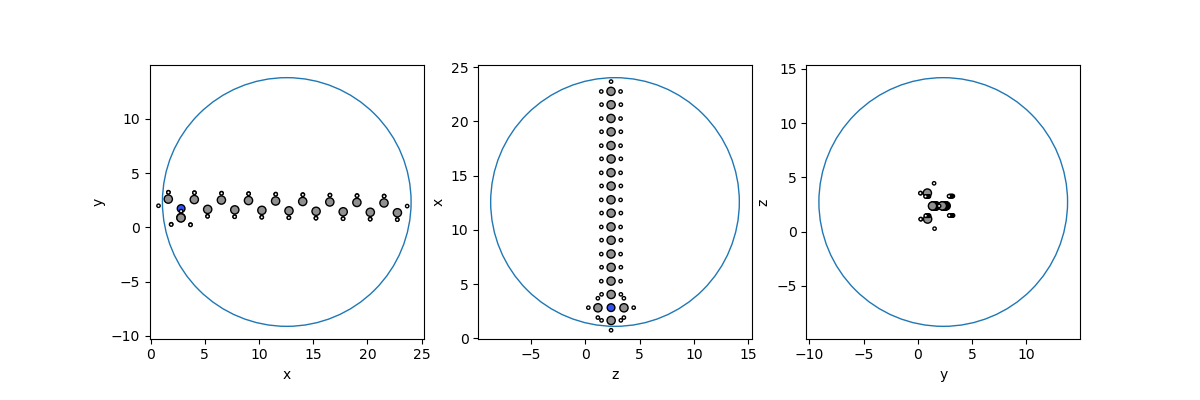

In [36]:
obj_list[0]

## Energy minimization after solvation analysis

### Overview on objects in step

In [37]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsEnergyMinimizationAfterSolvation'}
}

In [38]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

947

In [39]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [40]:
res_df

type               name  \
0                              mp4_file                NaN   
1                  surfactant_tail_rmsd                NaN   
2                  surfactant_head_rmsd                NaN   
3                        substrate_rmsd                NaN   
4                       counterion_rmsd                NaN   
5   surfactant_tail_surfactant_tail_rdf                NaN   
6   surfactant_head_surfactant_tail_rdf                NaN   
7   surfactant_head_surfactant_head_rdf                NaN   
8         substrate_surfactant_tail_rdf                NaN   
9         substrate_surfactant_head_rdf                NaN   
10       counterion_surfactant_tail_rdf                NaN   
11       counterion_surfactant_head_rdf                NaN   
12             counterion_substrate_rdf                NaN   
13            counterion_counterion_rdf                NaN   
14                      trajectory_file                NaN   
15                             run_file                NaN   
16                        topology_file                NaN   
17                            data_file                NaN   
18         uncompressed_trajectory_file                NaN   
19                          energy_file                NaN   
20                             log_file                NaN   
21                                input  view.pml.template   
22                                input    em_solvated.mdp   

                      earliest                      latest  object_count  
0   2020-10-13 23:31:57.798517  2020-10-13 23:31:58.871696            44  
1   2020-10-13 23:31:57.798515  2020-10-13 23:31:58.871693            44  
2   2020-10-13 23:31:57.798513  2020-10-13 23:31:58.871691            44  
3   2020-10-13 23:31:57.798510  2020-10-13 23:31:58.871689            44  
4   2020-10-13 23:31:57.798508  2020-10-13 23:31:58.871687            44  
5   2020-10-13 23:31:57.798506  2020-10-13 23:31:58.871685            44  
6   2020-10-13 23:31:57.798504  2020-10-13 23:31:58.871682            45  
7   2020-10-13 23:31:57.798501  2020-10-13 23:31:58.871680            45  
8   2020-10-13 23:31:57.798499  2020-10-13 23:31:58.871678            45  
9   2020-10-13 23:31:57.798497  2020-10-13 23:31:58.871676            45  
10  2020-10-13 23:31:57.798495  2020-10-13 23:31:58.871674            45  
11  2020-10-13 23:31:57.798492  2020-10-13 23:31:58.871671            45  
12  2020-10-13 23:31:57.798490  2020-10-13 23:31:58.871669            45  
13  2020-10-13 23:31:57.798488  2020-10-13 23:31:58.871667            45  
14  2020-10-13 23:31:57.798486  2020-10-13 23:31:58.871665            45  
15  2020-10-13 23:31:57.798483  2020-10-13 23:31:58.871663            46  
16  2020-10-13 23:31:57.798481  2020-10-13 23:31:58.871660            46  
17  2020-10-13 23:31:57.798479  2020-10-13 23:31:58.871658            46  
18  2020-10-13 23:31:57.798476  2020-10-13 23:31:58.871656            46  
19  2020-10-13 23:31:57.798473  2020-10-13 23:31:58.871653            46  
20  2020-10-13 23:31:57.798467  2020-10-13 23:31:58.871647            46  
21                        None                        None             1  
22                        None                        None             1

### Global observables

In [41]:
query = { 
    "metadata.project": project_id,
    'metadata.step': {'$regex': 'GromacsEnergyMinimizationAfterSolvation'},
    "metadata.type": 'energy_file',
}
fp.filepad.count_documents(query)

46

In [60]:
#parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}
#parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules',
    'shape': 'metadata.system.surfactant.aggregates.shape'
}

In [61]:
parameter_keys = list(parameter_dict.keys())

In [62]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [66]:
res_mi_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        try:
            em_df = panedr.edr_to_df(tmp.name)
        except:
            logger.warning("Failed reading edr for {}".format(metadata))
            continue
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),em_df.index],
            names=[*c["_id"].keys(),'step'])
        em_mi_df = em_df.set_index(mi)        
        res_mi_list.append(em_mi_df)
    print('.',end='')
print('')

res_mi_df = pd.concat(res_mi_list)
res_df = res_mi_df.reset_index()

ValueError: No objects to concatenate

In [ ]:
res_mi_df

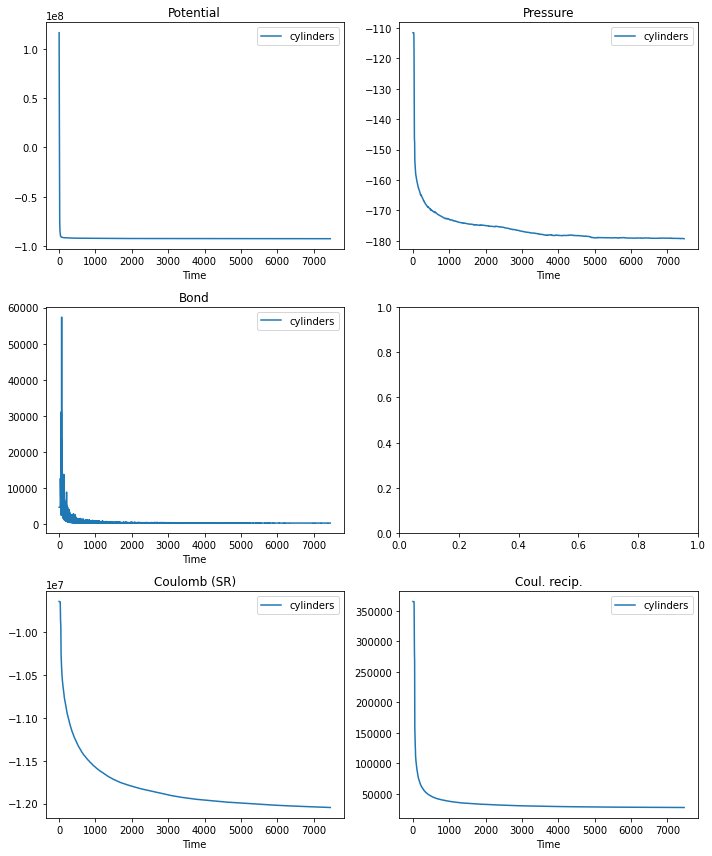

In [64]:
y_quantities = [
    'Potential',
    'Pressure',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

positions = [
    (0,0),
    (0,1),
    (1,0),
    (2,0),
    (2,1),
]
fig, ax = plt.subplots(3,2,figsize=(10,12))
for key, grp in res_df.groupby(parameter_keys[0]):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

###  Visualize trajectory

In [67]:
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsEnergyMinimizationAfterSolvation'},
    'metadata.type': 'mp4_file',
}

In [68]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

44

In [69]:
# check

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'nmolecules': '$metadata.system.surfactant.nmolecules'
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

# for i, c in enumerate(cursor): 
#    content, metadata = fp.get_file_by_id(c["latest"])
#    nmolecules = int(c["_id"]["nmolecules"])
    

res = [ {**c['_id'], **c} for c in cursor]
columns = ['nmolecules', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [70]:
res_df

nmolecules  name                    earliest                      latest  \
0         1944   NaN  2020-10-13 23:31:58.850377  2020-10-13 23:31:58.871696   
1         1863   NaN  2020-10-13 23:31:58.806421  2020-10-13 23:31:58.827543   
2         1782   NaN  2020-10-13 23:31:58.785597  2020-10-13 23:31:58.785597   
3         1701   NaN  2020-10-13 23:31:58.659185  2020-10-13 23:31:58.736016   
4         1620   NaN  2020-10-13 23:31:58.636198  2020-10-13 23:31:58.636198   
5         1539   NaN  2020-10-13 23:31:58.594170  2020-10-13 23:31:58.594170   
6         1458   NaN  2020-10-13 23:31:58.529462  2020-10-13 23:31:58.529462   
7         1377   NaN  2020-10-13 23:31:58.486650  2020-10-13 23:31:58.507798   
8         1296   NaN  2020-10-13 23:31:58.444974  2020-10-13 23:31:58.466124   
9         1215   NaN  2020-10-13 23:31:58.400662  2020-10-13 23:31:58.421435   
10        1134   NaN  2020-10-13 23:31:58.357968  2020-10-13 23:31:58.378932   
11        1053   NaN  2020-10-13 23:31:58.312030  2020-10-13 23:31:58.332801   
12         972   NaN  2020-10-13 23:31:58.270321  2020-10-13 23:31:58.291287   
13         891   NaN  2020-10-13 23:31:58.226158  2020-10-13 23:31:58.248728   
14         810   NaN  2020-10-13 23:31:58.184143  2020-10-13 23:31:58.205036   
15         729   NaN  2020-10-13 23:31:58.141455  2020-10-13 23:31:58.163404   
16         648   NaN  2020-10-13 23:31:58.098172  2020-10-13 23:31:58.119601   
17         567   NaN  2020-10-13 23:31:58.056085  2020-10-13 23:31:58.076899   
18         486   NaN  2020-10-13 23:31:58.013506  2020-10-13 23:31:58.035070   
19         405   NaN  2020-10-13 23:31:57.970518  2020-10-13 23:31:57.992373   
20         324   NaN  2020-10-13 23:31:57.927512  2020-10-13 23:31:57.949348   
21         243   NaN  2020-10-13 23:31:57.885000  2020-10-13 23:31:57.906330   
22         162   NaN  2020-10-13 23:31:57.843254  2020-10-13 23:31:57.864389   
23          81   NaN  2020-10-13 23:31:57.798517  2020-10-13 23:31:57.819837   

    object_count  
0              2  
1              2  
2              1  
3              2  
4              1  
5              1  
6              1  
7              2  
8              2  
9              2  
10             2  
11             2  
12             2  
13             2  
14             2  
15             2  
16             2  
17             2  
18             2  
19             2  
20             2  
21             2  
22             2  
23             2

In [71]:
parameter_keys

['nmolecules', 'shape']

In [72]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        obj_dict.update({c["_id"][parameter_keys[0]]: Video.from_file(tmp.name)})
    print('.',end='')

............................................

In [73]:
c

{'_id': {'nmolecules': 81, 'shape': 'bilayer'},
 'degeneracy': 1,
 'latest': '5f8676eafd2a730dccbb56ff'}

In [74]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

1944


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x00_Qmdat\x00\x00\…

1863


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x00`lmdat\x00\x00\…

1782


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x00]\xb5mdat\x00\x…

1701


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x03\xeb\xa4mdat\x0…

1620


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02(\xbbmdat\x00\x…

1539


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02\x17\xd1mdat\x0…

1458


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02ypmdat\x00\x00\…

1377


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x03\x8aDmdat\x00\x…

1296


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x03P\xe4mdat\x00\x…

1215


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x03/@mdat\x00\x00\…

1134


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x03D\xd2mdat\x00\x…

1053


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02)\xbemdat\x00\x…

972


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02\x18\xc2mdat\x0…

891


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01\xf4\xc0mdat\x0…

810


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02\xc4Omdat\x00\x…

729


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02\xa2\xbemdat\x0…

648


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02\x98\xa6mdat\x0…

567


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02\x8d\xf7mdat\x0…

486


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02\x83@mdat\x00\x…

405


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01\xa7\xe2mdat\x0…

324


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01\x9e\xfemdat\x0…

243


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01\x94\xc0mdat\x0…

162


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01Z\xe7mdat\x00\x…

81


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01\thmdat\x00\x00…

## NVT equilibration analysis

### Overview on objects in step

In [75]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsNVTEquilibration'}
}

In [76]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

631

In [77]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [78]:
res_df

type     name                    earliest  \
0                              mp4_file      NaN  2020-10-13 23:31:57.803269   
1                  surfactant_tail_rmsd      NaN  2020-10-13 23:31:57.803267   
2                  surfactant_head_rmsd      NaN  2020-10-13 23:31:57.803264   
3                        substrate_rmsd      NaN  2020-10-13 23:31:57.803262   
4                       counterion_rmsd      NaN  2020-10-13 23:31:57.803260   
5   surfactant_tail_surfactant_tail_rdf      NaN  2020-10-13 23:31:57.803258   
6   surfactant_head_surfactant_tail_rdf      NaN  2020-10-13 23:31:57.803256   
7   surfactant_head_surfactant_head_rdf      NaN  2020-10-13 23:31:57.803253   
8         substrate_surfactant_tail_rdf      NaN  2020-10-13 23:31:57.803251   
9         substrate_surfactant_head_rdf      NaN  2020-10-13 23:31:57.803249   
10       counterion_surfactant_tail_rdf      NaN  2020-10-13 23:31:57.803247   
11       counterion_surfactant_head_rdf      NaN  2020-10-13 23:31:57.803244   
12             counterion_substrate_rdf      NaN  2020-10-13 23:31:57.803242   
13            counterion_counterion_rdf      NaN  2020-10-13 23:31:57.803240   
14                             run_file      NaN  2020-10-13 23:31:57.803238   
15                           index_file      NaN  2020-10-13 23:31:57.803235   
16                        topology_file      NaN  2020-10-13 23:31:57.803233   
17                            data_file      NaN  2020-10-13 23:31:57.803231   
18                      trajectory_file      NaN  2020-10-13 23:31:57.803228   
19                          energy_file      NaN  2020-10-13 23:31:57.803226   
20                             log_file      NaN  2020-10-13 23:31:57.803220   
21                                input  nvt.mdp                        None   

                        latest  object_count  
0   2020-10-13 23:31:58.855226            30  
1   2020-10-13 23:31:58.855224            30  
2   2020-10-13 23:31:58.855222            30  
3   2020-10-13 23:31:58.855219            30  
4   2020-10-13 23:31:58.855217            30  
5   2020-10-13 23:31:58.855215            30  
6   2020-10-13 23:31:58.855213            30  
7   2020-10-13 23:31:58.855211            30  
8   2020-10-13 23:31:58.855208            30  
9   2020-10-13 23:31:58.855206            30  
10  2020-10-13 23:31:58.855204            30  
11  2020-10-13 23:31:58.855202            30  
12  2020-10-13 23:31:58.855199            30  
13  2020-10-13 23:31:58.855197            30  
14  2020-10-13 23:31:58.855195            30  
15  2020-10-13 23:31:58.855193            30  
16  2020-10-13 23:31:58.855190            30  
17  2020-10-13 23:31:58.855188            30  
18  2020-10-13 23:31:58.855186            30  
19  2020-10-13 23:31:58.855183            30  
20  2020-10-13 23:31:58.855177            30  
21                        None             1

### Global observables

In [88]:
query = { 
    "metadata.project": project_id,
    'metadata.step': {'$regex': 'GromacsNVTEquilibration'},
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

30

In [89]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules',
    'shape': 'metadata.system.surfactant.aggregates.shape'
}

parameter_keys = list(parameter_dict.keys())

In [99]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [112]:
res_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [ *[[v] for v in c["_id"].values()],res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

..............................


In [113]:
res_df.columns

Index(['nmolecules', 'shape', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.',
       'LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.',
       'Position Rest.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pressure', 'Constr. rmsd', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-14:Surfactant-Ion',
       'Coul-SR:Surfactant-rest', 'LJ-SR:Surfactant-rest',
       'Coul-14:Surfactant-rest', '

In [114]:
res_df_mi

Time          Bond            U-B   Proper Dih.  \
nmolecules shape   step                                                      
405        bilayer 0.0      0.0    336.762299    5609.709473  15275.146484   
                   1.0      1.0   5569.974609   40000.382812  20775.585938   
                   2.0      2.0   6615.566406   46112.875000  21897.025391   
                   3.0      3.0   7130.301758   50295.371094  22627.021484   
                   4.0      4.0   7601.223633   53907.386719  22971.468750   
...                         ...           ...            ...           ...   
1296       bilayer 96.0    96.0  26367.396484  191188.453125  78572.117188   
                   97.0    97.0  25973.251953  191302.937500  78590.515625   
                   98.0    98.0  26293.732422  190148.890625  78993.523438   
                   99.0    99.0  26275.277344  190356.203125  78729.914062   
                   100.0  100.0  26459.773438  191251.671875  78547.992188   

                                LJ-14    Coulomb-14     LJ (SR)  Coulomb (SR)  \
nmolecules shape   step                                                         
405        bilayer 0.0    -938.929871 -4.498196e+05 -79815064.0   -12370052.0   
                   1.0     -77.371773 -4.500497e+05 -80003904.0   -10990010.0   
                   2.0     148.110474 -4.500002e+05 -80063808.0   -10682512.0   
                   3.0     302.290680 -4.501067e+05 -80122520.0   -10447955.0   
                   4.0     399.675079 -4.504439e+05 -80170184.0   -10269777.0   
...                               ...           ...         ...           ...   
1296       bilayer 96.0   2578.112793 -1.441748e+06 -80406624.0    -8529983.0   
                   97.0   2640.567139 -1.441809e+06 -80405984.0    -8527396.0   
                   98.0   2589.545166 -1.441626e+06 -80409384.0    -8529375.0   
                   99.0   2658.798096 -1.441912e+06 -80411120.0    -8522873.0   
                   100.0  2645.103271 -1.441487e+06 -80403800.0    -8533594.0   

                          ...  Coul-SR:rest-rest  LJ-SR:rest-rest  \
nmolecules shape   step   ...                                       
405        bilayer 0.0    ...        -12550173.0     1.441314e+06   
                   1.0    ...        -11167832.0     1.273080e+06   
                   2.0    ...        -10852491.0     1.223366e+06   
                   3.0    ...        -10619445.0     1.171972e+06   
                   4.0    ...        -10443889.0     1.129002e+06   
...                       ...                ...              ...   
1296       bilayer 96.0   ...         -9151689.0     9.921227e+05   
                   97.0   ...         -9147254.0     9.903748e+05   
                   98.0   ...         -9149565.0     9.883881e+05   
                   99.0   ...         -9144062.0     9.875896e+05   
                   100.0  ...         -9154591.0     9.926151e+05   

                          Coul-14:rest-rest  LJ-14:rest-rest  T-non-Substrate  \
nmolecules shape   step                                                         
405        bilayer 0.0                  0.0              0.0       299.153046   
                   1.0                  0.0              0.0       205.595612   
                   2.0                  0.0              0.0       237.888718   
                   3.0                  0.0              0.0       256.536438   
                   4.0                  0.0              0.0       267.331085   
...                                     ...              ...              ...   
1296       bilayer 96.0                 0.0              0.0       298.348053   
                   97.0                 0.0              0.0       297.865540   
                   98.0                 0.0              0.0       298.765686   
                   99.0                 0.0              0.0       298.079498   
                   100.0                0.0              0.0       298.365936   

      

<ipython-input-117-bb605528b000>:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


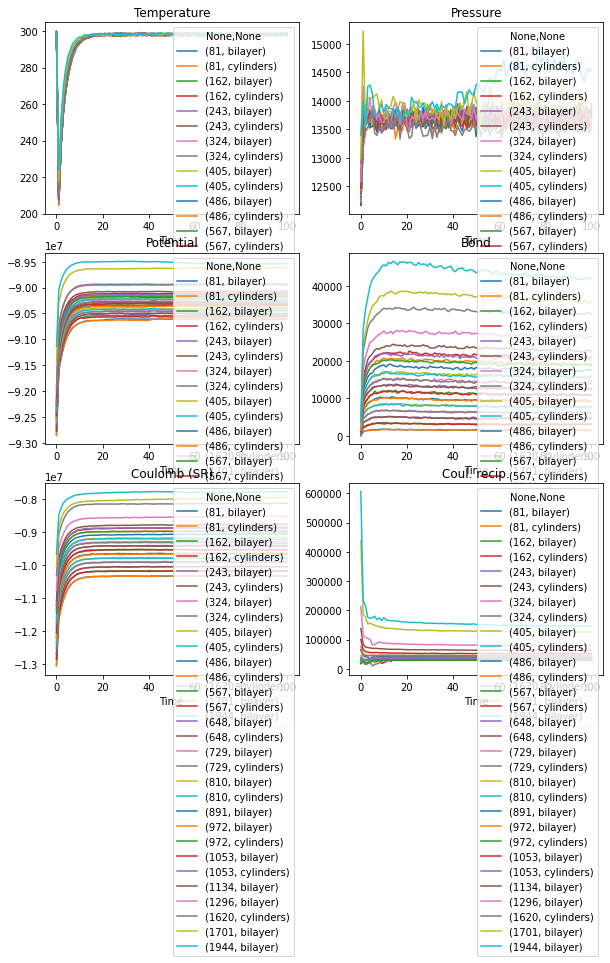

In [117]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(parameter_keys):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [118]:
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsNVTEquilibration'},
    'metadata.type': 'mp4_file',
}

In [119]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

30

In [120]:
#parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}
#parameter_dict = {'shape': 'metadata.system.surfactant.aggregates.shape'}
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

..............................

In [121]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

('cylinders', 1053)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0f|\x84mdat\x00\x…

('cylinders', 324)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0b.\x06mdat\x00\x…

('cylinders', 162)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xb5Dmdat\x00\x…

('cylinders', 405)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x07m_mdat\x00\x00\…

('cylinders', 243)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\n\x7f\x19mdat\x00\…

('cylinders', 567)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08Y\x90mdat\x00\x…

('cylinders', 648)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08Q(mdat\x00\x00\…

('cylinders', 486)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0e\x1dVmdat\x00\x…

('cylinders', 81)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xb2\x81mdat\x0…

('cylinders', 729)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0e\\\xd3mdat\x00\…

('cylinders', 972)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08\x96\xfbmdat\x0…

('cylinders', 1620)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x07\xedamdat\x00\x…

('cylinders', 810)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08h\xebmdat\x00\x…

('bilayer', 729)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08\x9f(mdat\x00\x…

('bilayer', 1134)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0f\x91\x0fmdat\x0…

('bilayer', 81)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\x12imdat\x00\x…

('bilayer', 162)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08\xefOmdat\x00\x…

('bilayer', 1053)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0fc\xcdmdat\x00\x…

('bilayer', 891)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0fi\xa9mdat\x00\x…

('bilayer', 810)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08W\xf7mdat\x00\x…

('bilayer', 1701)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0fi\x19mdat\x00\x…

('bilayer', 243)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\nWOmdat\x00\x00\x0…

('bilayer', 486)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\r\xc9\x10mdat\x00\…

('bilayer', 324)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0b\xe6smdat\x00\x…

('bilayer', 405)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\r>Wmdat\x00\x00\x0…

('bilayer', 1296)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0f\xe6 mdat\x00\x…

('bilayer', 567)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x07\xefGmdat\x00\x…

('bilayer', 648)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0e\xd3\xe2mdat\x0…

('bilayer', 1944)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0f\xae\x08mdat\x0…

('bilayer', 972)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0f\x06dmdat\x00\x…

## NPT equilibration analysis

### Overview on objects in step

In [122]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsNPTEquilibration:push_filepad'}
}

In [123]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

567

In [124]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [125]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-10-13 23:31:57.808469   
1                  surfactant_tail_rmsd   NaN  2020-10-13 23:31:57.808467   
2                  surfactant_head_rmsd   NaN  2020-10-13 23:31:57.808464   
3                        substrate_rmsd   NaN  2020-10-13 23:31:57.808462   
4                       counterion_rmsd   NaN  2020-10-13 23:31:57.808460   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-10-13 23:31:57.808458   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-10-13 23:31:57.808455   
7   surfactant_head_surfactant_head_rdf   NaN  2020-10-13 23:31:57.808453   
8         substrate_surfactant_tail_rdf   NaN  2020-10-13 23:31:57.808451   
9         substrate_surfactant_head_rdf   NaN  2020-10-13 23:31:57.808449   
10       counterion_surfactant_tail_rdf   NaN  2020-10-13 23:31:57.808446   
11       counterion_surfactant_head_rdf   NaN  2020-10-13 23:31:57.808444   
12             counterion_substrate_rdf   NaN  2020-10-13 23:31:57.808442   
13            counterion_counterion_rdf   NaN  2020-10-13 23:31:57.808440   
14                             run_file   NaN  2020-10-13 23:31:57.808438   
15                           index_file   NaN  2020-10-13 23:31:57.808435   
16                        topology_file   NaN  2020-10-13 23:31:57.808433   
17                            data_file   NaN  2020-10-13 23:31:57.808431   
18                      trajectory_file   NaN  2020-10-13 23:31:57.808429   
19                          energy_file   NaN  2020-10-13 23:31:57.808425   
20                             log_file   NaN  2020-10-13 23:31:57.808419   

                        latest  object_count  
0   2020-10-13 23:31:58.860104            27  
1   2020-10-13 23:31:58.860101            27  
2   2020-10-13 23:31:58.860099            27  
3   2020-10-13 23:31:58.860097            27  
4   2020-10-13 23:31:58.860095            27  
5   2020-10-13 23:31:58.860092            27  
6   2020-10-13 23:31:58.860090            27  
7   2020-10-13 23:31:58.860088            27  
8   2020-10-13 23:31:58.860086            27  
9   2020-10-13 23:31:58.860084            27  
10  2020-10-13 23:31:58.860081            27  
11  2020-10-13 23:31:58.860079            27  
12  2020-10-13 23:31:58.860076            27  
13  2020-10-13 23:31:58.860074            27  
14  2020-10-13 23:31:58.860072            27  
15  2020-10-13 23:31:58.860070            27  
16  2020-10-13 23:31:58.860067            27  
17  2020-10-13 23:31:58.860065            27  
18  2020-10-13 23:31:58.860063            27  
19  2020-10-13 23:31:58.860060            27  
20  2020-10-13 23:31:58.860054            27

### Global observables

In [126]:
query = { 
    "metadata.project": project_id,
    'metadata.step': {'$regex': 'GromacsNPTEquilibration'},
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

27

In [127]:
metadata = fp.filepad.find_one(query)

In [128]:
metadata

{'_id': ObjectId('5f8687378752d7b81fa747ec'),
 'identifier': '/p/scratch/chfr13/hoermann/fireworks/launchpad/launcher_2020-10-14-05-05-57-308899/default.edr',
 'original_file_name': 'default.edr',
 'original_file_path': '/p/scratch/chfr13/hoermann/fireworks/launchpad/launcher_2020-10-14-05-05-57-308899/default.edr',
 'metadata': {'project': '2020-10-13-ctab-on-au-111-substrate-passivation',
  'datetime': '2020-10-13 23:31:58.151029',
  'step': 'SubstratePassivation:BilayerPackingAndEquilibartion:GromacsMinimizationEquilibrationRelaxation:GromacsNPTEquilibration:push_filepad',
  'source_project_id': '2020-09-27-au-111-fcc-substrate-creation',
  'source_step': 'FCCSubstrateCreationChainWorkflowGenerator:LAMMPSEquilibrationNPTWorkflowGenerator:push_filepad',
  'metadata_fp_source_key': 'metadata->system->substrate',
  'metadata_fw_dest_key': 'metadata->system->substrate',
  'metadata_fw_source_key': 'metadata->system->substrate',
  'description': 'CTAB on Au(111) substrate passivation',
 

In [130]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())


In [131]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [132]:
[ c for c in cursor]

[{'_id': {'shape': 'bilayer', 'nmolecules': 972},
  'degeneracy': 1,
  'latest': '5f86967ffd2a730dccbbc7b8'},
 {'_id': {'shape': 'cylinders', 'nmolecules': 567},
  'degeneracy': 1,
  'latest': '5f8692fb6b7f8f8ab3bbe5b5'},
 {'_id': {'shape': 'cylinders', 'nmolecules': 243},
  'degeneracy': 1,
  'latest': '5f868b04beec446e55bb4f8c'},
 {'_id': {'shape': 'cylinders', 'nmolecules': 1053},
  'degeneracy': 1,
  'latest': '5f86ac660bda12f287bbe0af'},
 {'_id': {'shape': 'cylinders', 'nmolecules': 729},
  'degeneracy': 1,
  'latest': '5f86a860beec446e55bbae82'},
 {'_id': {'shape': 'cylinders', 'nmolecules': 486},
  'degeneracy': 1,
  'latest': '5f86930cfd2a730dccbbbf8e'},
 {'_id': {'shape': 'bilayer', 'nmolecules': 243},
  'degeneracy': 1,
  'latest': '5f868c31beec446e55bb57dc'},
 {'_id': {'shape': 'bilayer', 'nmolecules': 324},
  'degeneracy': 1,
  'latest': '5f868b2f0bda12f287bb715d'},
 {'_id': {'shape': 'cylinders', 'nmolecules': 162},
  'degeneracy': 1,
  'latest': '5f868c0afd2a730dccbb8c45'

In [136]:
res_list = []

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [*[[v] for v in c["_id"].values()],res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

...........................


In [137]:
res_df.columns

Index(['shape', 'nmolecules', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.',
       'LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.',
       'Position Rest.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pressure', 'Constr. rmsd', 'Box-X',
       'Box-Y', 'Box-Z', 'Volume', 'Density', 'pV', 'Enthalpy', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-14:Surfactant-Ion',
       'Coul-SR:Surfa

In [138]:
res_df_mi

Time          Bond            U-B   Proper Dih.  \
shape     nmolecules step                                                      
cylinders 810        0.0      0.0  16264.279297  111387.351562  47319.957031   
                     1.0      1.0  15515.659180  110481.304688  46982.023438   
                     2.0      2.0  15478.591797  110853.617188  47119.957031   
                     3.0      3.0  15364.682617  110848.882812  47307.242188   
                     4.0      4.0  15798.178711  111745.476562  47222.941406   
...                           ...           ...            ...           ...   
bilayer   81         96.0    96.0   1552.198853   10467.779297   4443.123535   
                     97.0    97.0   1494.216919   10431.462891   4498.831543   
                     98.0    98.0   1549.523193   10514.641602   4563.296387   
                     99.0    99.0   1509.640869   10488.359375   4554.408203   
                     100.0  100.0   1601.009888   10445.417969   4558.555176   

                                  LJ-14     Coulomb-14     LJ (SR)  \
shape     nmolecules step                                            
cylinders 810        0.0     983.418762 -901366.062500 -80354296.0   
                     1.0     959.010559 -901346.687500 -83095416.0   
                     2.0     972.424255 -900498.750000 -83534792.0   
                     3.0     952.557922 -900446.187500 -83798248.0   
                     4.0    1019.889893 -900592.562500 -83945688.0   
...                                 ...            ...         ...   
bilayer   81         96.0     85.521164  -90029.156250 -84102888.0   
                     97.0     63.239334  -90148.429688 -84102632.0   
                     98.0     92.133003  -90010.804688 -84108072.0   
                     99.0     91.772423  -89981.796875 -84106640.0   
                     100.0    61.140762  -90089.460938 -84100352.0   

                            Coulomb (SR)  ...  Coul-SR:rest-rest  \
shape     nmolecules step                 ...                      
cylinders 810        0.0      -9223811.0  ...         -9568941.0   
                     1.0      -9230427.0  ...         -9574447.0   
                     2.0      -9241975.0  ...         -9586517.0   
                     3.0      -9236665.0  ...         -9581678.0   
                     4.0      -9253651.0  ...         -9597190.0   
...                                  ...  ...                ...   
bilayer   81         96.0    -10427179.0  ...        -10460852.0   
                     97.0    -10427323.0  ...        -10460611.0   
                     98.0    -10419038.0  ...        -10452306.0   
                     99.0    -10422105.0  ...        -10455053.0   
                     100.0   -10431736.0  ...        -10465069.0   

                            LJ-SR:rest-rest  Coul-14:rest-rest  \
shape     nmolecules step                                        
cylinders 810        0.0       9.973058e+05                0.0   
                     1.0       9.963634e+05                0.0   
                     2.0       1.001856e+06                0.0   
                     3.0       9.992972e+05                0.0   
                     4.0       1.005388e+06                0.0   
...                                     ...                ...   
bilayer   81         96.0      1.082824e+06                0.0   
                     97.0      1.083273e+06                0.0   
                     98.0      1.077700e+06                0.0   
                     99.0      1.078925e+06                0.0   
                     100.0     1.085661e+06                0.0   

                            LJ-14:rest-rest  T-non-Substrate  T-Substrate  \
shape     nmolecules step                                                   
cylinders 810        0.0                0.0       298.966431     0.905010   
                     1.0                0.0       297.083038   202.890442   
                     2.0 

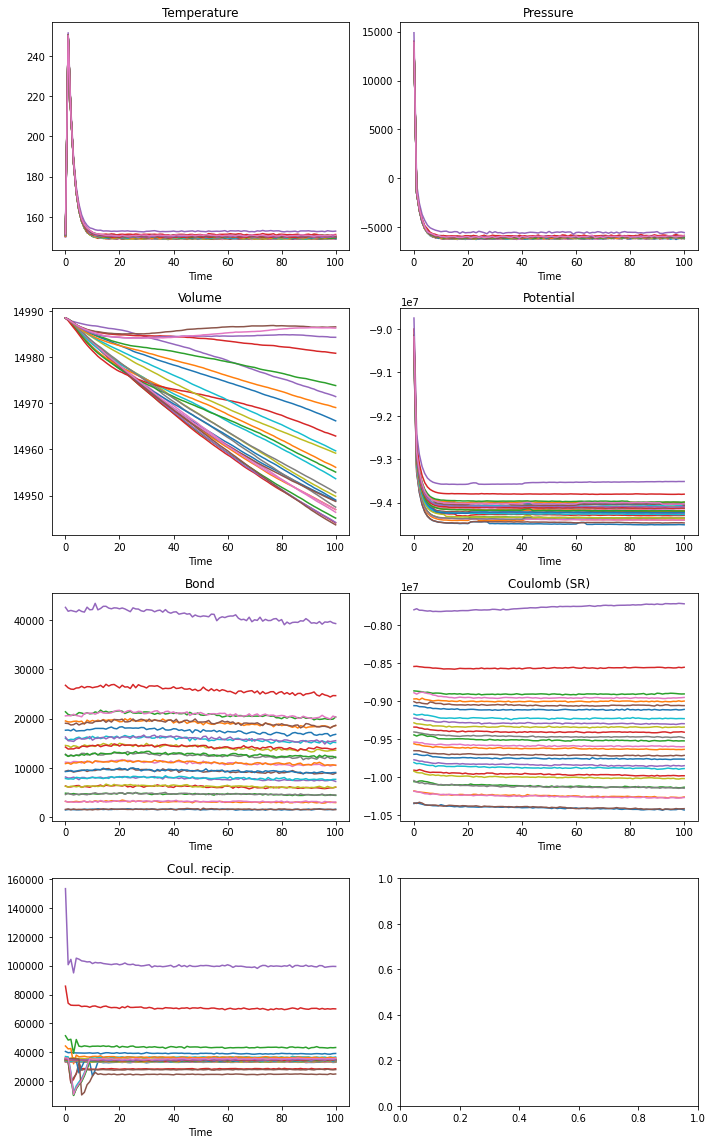

In [148]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Volume',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(parameter_keys):
    for y_quantity, position in zip(y_quantities, positions):
        # grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        grp.plot('Time',y_quantity,ax=ax[position],legend=False,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [153]:
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsNPTEquilibration'},
    'metadata.type': 'mp4_file',
}

In [154]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

27

In [155]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

In [156]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

...........................

In [157]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

('cylinders', 972)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0c\tZmdat\x00\x00…

('cylinders', 648)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\n\xd2\xf3mdat\x00\…

('cylinders', 324)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0b\xfd\xb0mdat\x0…

('cylinders', 405)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08i(mdat\x00\x00\…

('cylinders', 567)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0by_mdat\x00\x00\…

('cylinders', 243)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0c\xda\xe2mdat\x0…

('cylinders', 1053)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x11_\x02mdat\x00\x…

('cylinders', 729)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0f!;mdat\x00\x00\…

('cylinders', 486)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10X\x16mdat\x00\x…

('cylinders', 162)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0b\x16lmdat\x00\x…

('cylinders', 81)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08\x11\xb9mdat\x0…

('cylinders', 810)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\n\xe4\xc2mdat\x00\…

('bilayer', 162)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x07\x0e$mdat\x00\x…

('bilayer', 81)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xd1Fmdat\x00\x…

('bilayer', 648)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x102\xb6mdat\x00\x…

('bilayer', 1053)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\t\x0e\x83mdat\x00\…

('bilayer', 810)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x11\x93fmdat\x00\x…

('bilayer', 891)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10l\x89mdat\x00\x…

('bilayer', 567)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0f\x04rmdat\x00\x…

('bilayer', 729)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0b*\xc6mdat\x00\x…

('bilayer', 486)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\na\x9bmdat\x00\x00…

('bilayer', 972)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10b\x8cmdat\x00\x…

('bilayer', 1944)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10\xca5mdat\x00\x…

('bilayer', 243)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0c\xe2-mdat\x00\x…

('bilayer', 324)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0e\x8c\x00mdat\x0…

('bilayer', 405)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0e\xc0\x91mdat\x0…

('bilayer', 1296)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x11q\x9dmdat\x00\x…


### Pre-evaluated RDF

#### Overview

In [158]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": {'$regex': "GromacsNPTEquilibration"},
}

fp.filepad.count_documents(query)

243

In [159]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [160]:
res_df

type                    earliest  \
0  surfactant_tail_surfactant_tail_rdf  2020-10-13 23:31:57.808458   
1  surfactant_head_surfactant_tail_rdf  2020-10-13 23:31:57.808455   
2  surfactant_head_surfactant_head_rdf  2020-10-13 23:31:57.808453   
3        substrate_surfactant_tail_rdf  2020-10-13 23:31:57.808451   
4        substrate_surfactant_head_rdf  2020-10-13 23:31:57.808449   
5       counterion_surfactant_tail_rdf  2020-10-13 23:31:57.808446   
6       counterion_surfactant_head_rdf  2020-10-13 23:31:57.808444   
7             counterion_substrate_rdf  2020-10-13 23:31:57.808442   
8            counterion_counterion_rdf  2020-10-13 23:31:57.808440   

                       latest  object_count  
0  2020-10-13 23:31:58.860092            27  
1  2020-10-13 23:31:58.860090            27  
2  2020-10-13 23:31:58.860088            27  
3  2020-10-13 23:31:58.860086            27  
4  2020-10-13 23:31:58.860084            27  
5  2020-10-13 23:31:58.860081            27  
6  2020-10-13 23:31:58.860079            27  
7  2020-10-13 23:31:58.860076            27  
8  2020-10-13 23:31:58.860074            27

#### Substrate - surfactant head RDF

In [161]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": {'$regex': "GromacsNPTEquilibration"},
}

fp.filepad.count_documents(query)

27

In [162]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

In [167]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

...........................


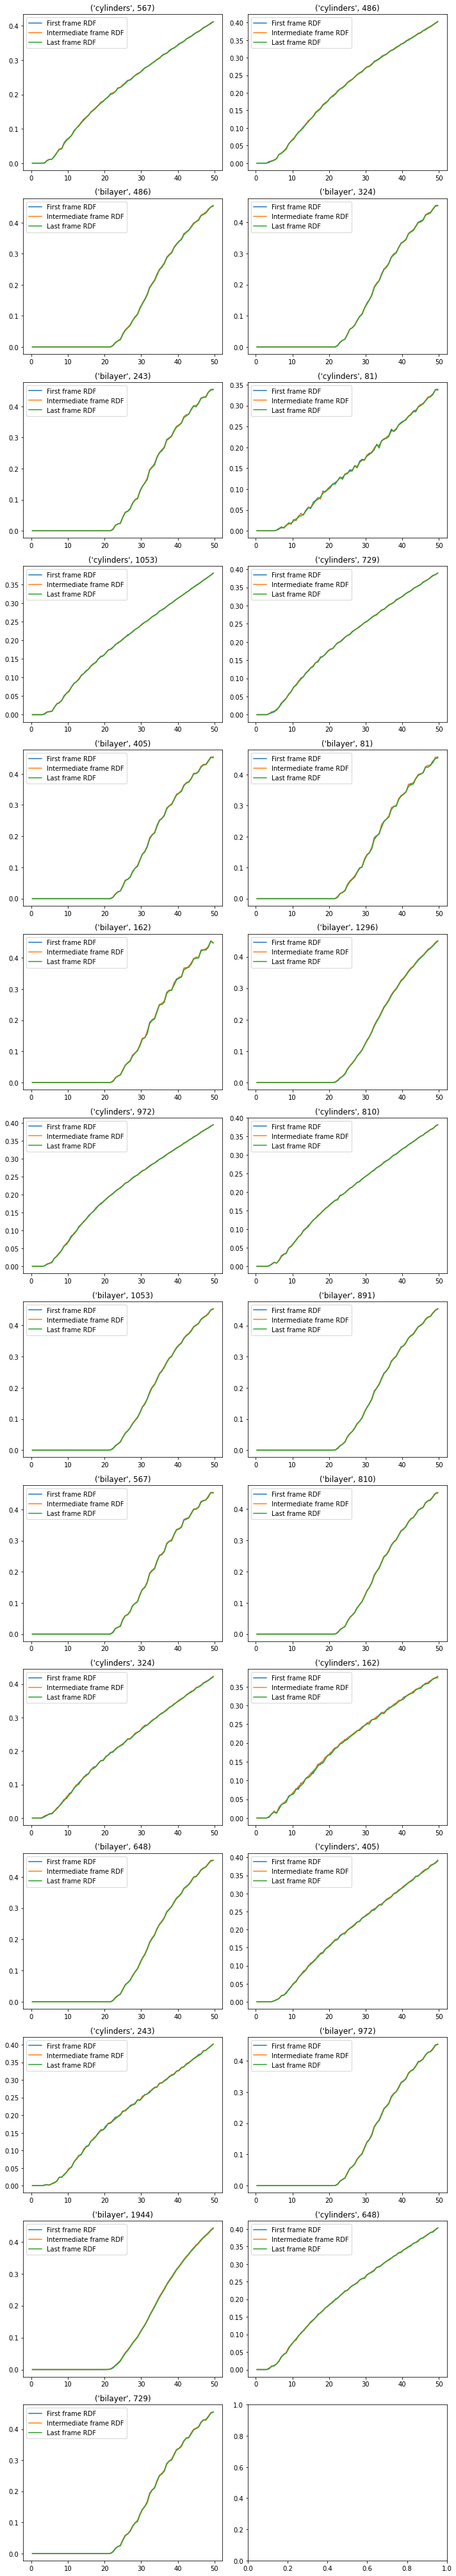

In [168]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Substrate - surfactant tail RDF

In [169]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsNPTEquilibration"},
}

fp.filepad.count_documents(query)

27

In [171]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

...........................


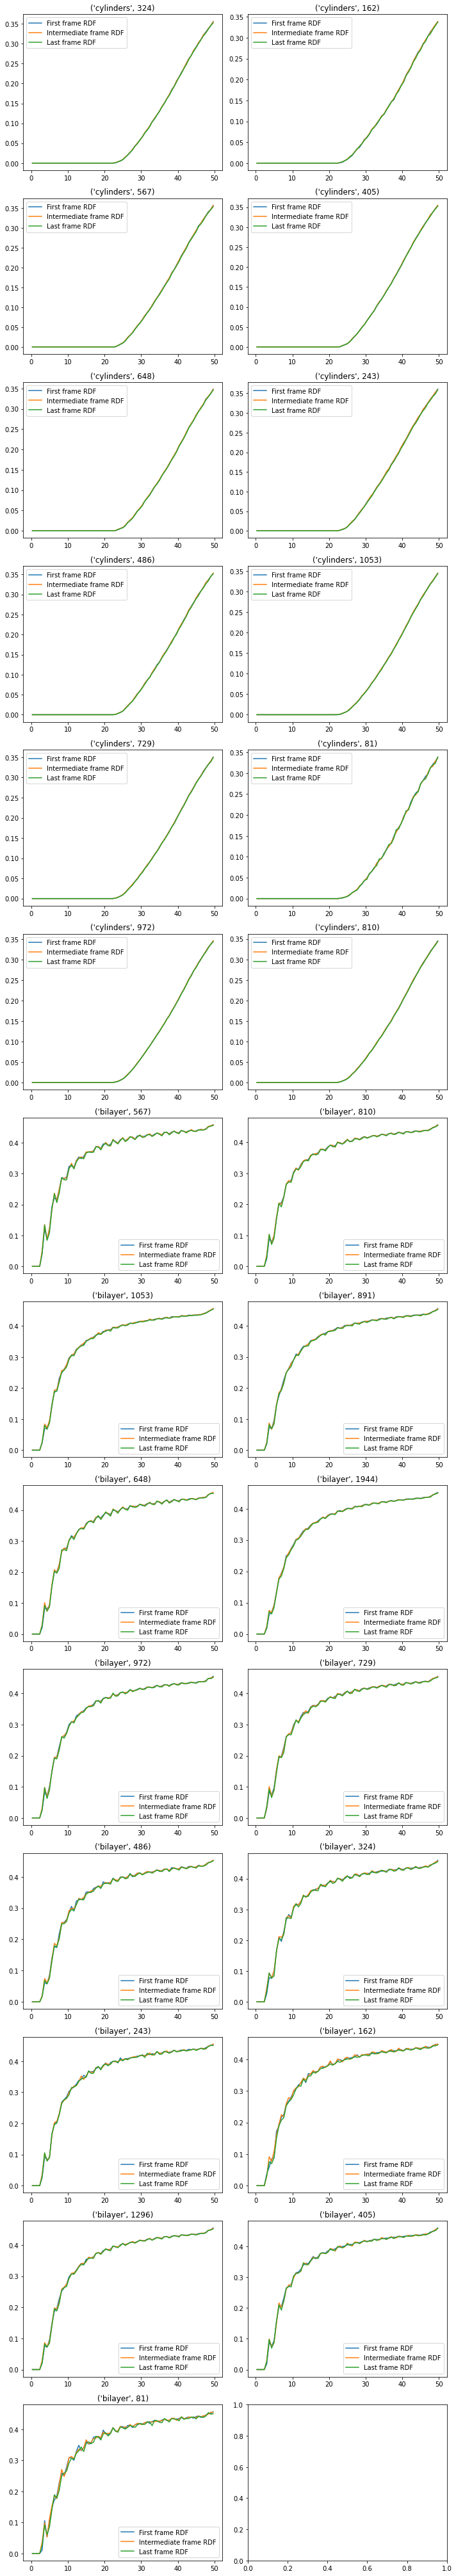

In [172]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
    
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant head - surfactant tail RDF

In [173]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsNPTEquilibration"},
}

fp.filepad.count_documents(query)

27

In [174]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
    }
}

aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

...........................


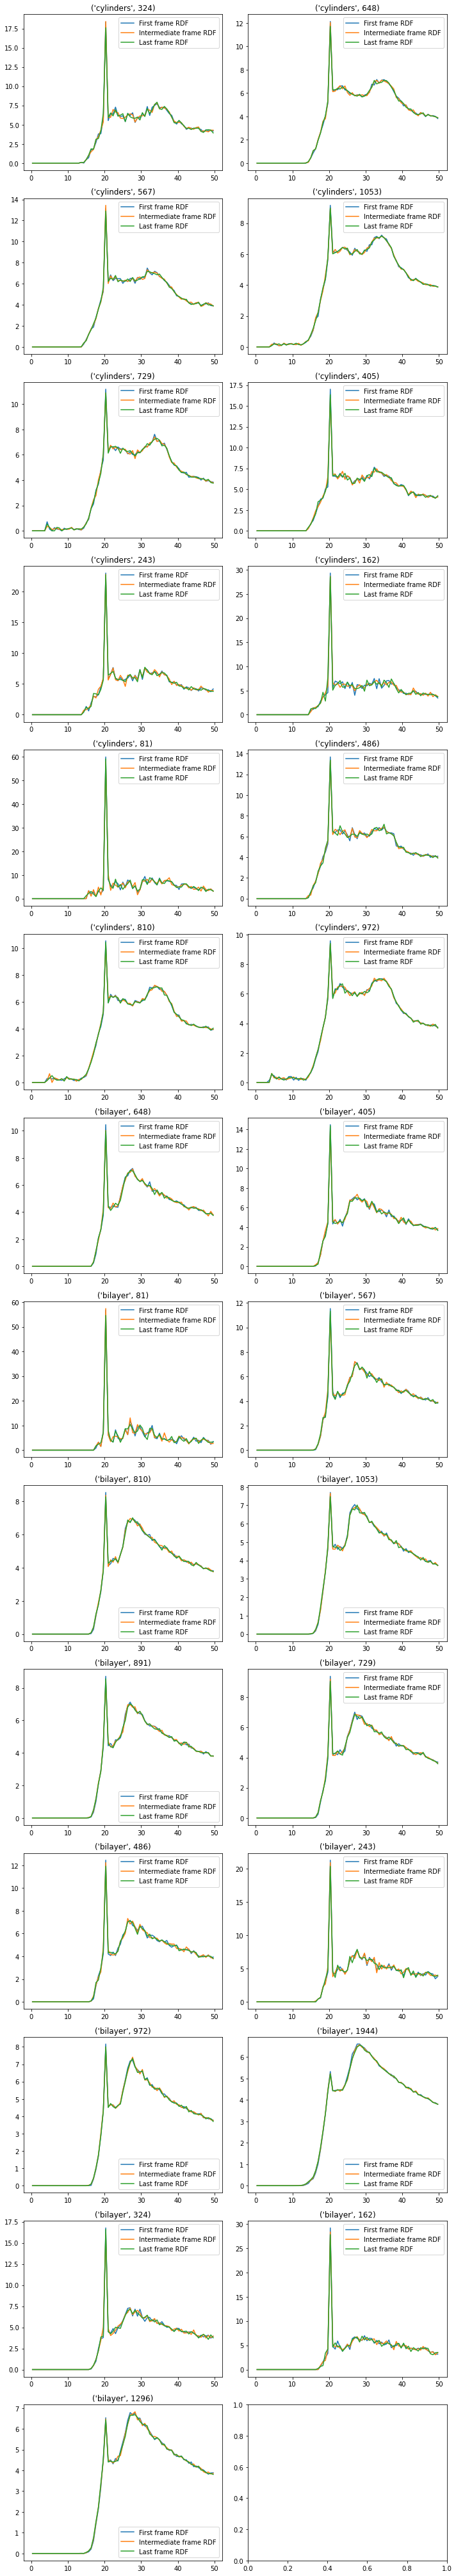

In [175]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

## Relaxation analysis

### Overview on objects in step

In [176]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsRelaxation'}
}

In [177]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

383

In [178]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [179]:
res_df

type              name  \
0                              mp4_file               NaN   
1                  surfactant_tail_rmsd               NaN   
2                  surfactant_head_rmsd               NaN   
3                        substrate_rmsd               NaN   
4                       counterion_rmsd               NaN   
5   surfactant_tail_surfactant_tail_rdf               NaN   
6   surfactant_head_surfactant_tail_rdf               NaN   
7   surfactant_head_surfactant_head_rdf               NaN   
8         substrate_surfactant_tail_rdf               NaN   
9         substrate_surfactant_head_rdf               NaN   
10       counterion_surfactant_tail_rdf               NaN   
11       counterion_surfactant_head_rdf               NaN   
12             counterion_substrate_rdf               NaN   
13            counterion_counterion_rdf               NaN   
14                           index_file               NaN   
15                             run_file               NaN   
16                        topology_file               NaN   
17                            data_file               NaN   
18                      trajectory_file               NaN   
19         uncompressed_trajectory_file               NaN   
20                          energy_file               NaN   
21                             log_file               NaN   
22                      checkpoint_file               NaN   
23                                input  relax_z_only.mdp   

                      earliest                      latest  object_count  
0   2020-10-13 23:31:57.921402  2020-10-13 23:31:58.157138             8  
1   2020-10-13 23:31:57.921399  2020-10-13 23:31:58.157136             8  
2   2020-10-13 23:31:57.921397  2020-10-13 23:31:58.157133             8  
3   2020-10-13 23:31:57.921395  2020-10-13 23:31:58.157131             8  
4   2020-10-13 23:31:57.921392  2020-10-13 23:31:58.157128             8  
5   2020-10-13 23:31:57.921390  2020-10-13 23:31:58.157126             8  
6   2020-10-13 23:31:57.921388  2020-10-13 23:31:58.157124             8  
7   2020-10-13 23:31:57.921386  2020-10-13 23:31:58.157122             8  
8   2020-10-13 23:31:57.921383  2020-10-13 23:31:58.157120             8  
9   2020-10-13 23:31:57.921381  2020-10-13 23:31:58.157117             8  
10  2020-10-13 23:31:57.921379  2020-10-13 23:31:58.157115             8  
11  2020-10-13 23:31:57.921376  2020-10-13 23:31:58.157113             8  
12  2020-10-13 23:31:57.921374  2020-10-13 23:31:58.157111             8  
13  2020-10-13 23:31:57.921372  2020-10-13 23:31:58.157108             8  
14  2020-10-13 23:31:57.921370  2020-10-13 23:31:58.157106             8  
15  2020-10-13 23:31:57.921367  2020-10-13 23:31:58.157104             8  
16  2020-10-13 23:31:57.921365  2020-10-13 23:31:58.157102             8  
17  2020-10-13 23:31:57.921363  2020-10-13 23:31:58.157099             8  
18  2020-10-13 23:31:57.921361  2020-10-13 23:31:58.157097             8  
19  2020-10-13 23:31:57.921358  2020-10-13 23:31:58.157095             8  
20  2020-10-13 23:31:57.814034  2020-10-13 23:31:58.865832            74  
21  2020-10-13 23:31:57.814031  2020-10-13 23:31:58.865829            74  
22  2020-10-13 23:31:57.814026  2020-10-13 23:31:58.865822            74  
23                        None                        None             1

### Global observables

In [194]:
query = { 
    "metadata.project": project_id,
    'metadata.step': {'$regex': 'GromacsRelaxation'},
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

74

In [195]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

In [196]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [197]:
res_list = []

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [*[[v] for v in c["_id"].values()],res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

........................


In [198]:
res_df.columns

Index(['shape', 'nmolecules', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.',
       'LJ-14', 'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.',
       'Position Rest.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pressure', 'Constr. rmsd', 'Box-X',
       'Box-Y', 'Box-Z', 'Volume', 'Density', 'pV', 'Enthalpy', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-14:Surfactant-Ion',
       'Coul-SR:Surfa

In [199]:
res_df_mi

Time          Bond            U-B  \
shape     nmolecules step                                          
bilayer   1944       0.0        0.0  39936.410156  289935.437500   
                     1.0        1.0  39717.855469  286455.187500   
                     2.0        2.0  39786.585938  282673.281250   
                     3.0        3.0  39369.175781  280971.593750   
                     4.0        4.0  39469.574219  280759.625000   
...                             ...           ...            ...   
cylinders 729        2996.0  2996.0  13508.846680   93825.765625   
                     2997.0  2997.0  13331.565430   93072.046875   
                     2998.0  2998.0  13445.263672   93784.937500   
                     2999.0  2999.0  13504.045898   93202.882812   
                     3000.0  3000.0  13544.460938   93906.226562   

                               Proper Dih.        LJ-14    Coulomb-14  \
shape     nmolecules step                                               
bilayer   1944       0.0     118923.296875  3601.251709 -2.160646e+06   
                     1.0     122287.273438  3941.893066 -2.157035e+06   
                     2.0     121678.007812  4082.935791 -2.155238e+06   
                     3.0     122375.289062  4018.603760 -2.151787e+06   
                     4.0     121373.687500  3896.191895 -2.150179e+06   
...                                    ...          ...           ...   
cylinders 729        2996.0   42622.656250   470.645233 -7.913297e+05   
                     2997.0   42518.507812   456.470490 -7.912239e+05   
                     2998.0   42998.128906   444.005981 -7.910263e+05   
                     2999.0   42822.843750   448.560028 -7.914327e+05   
                     3000.0   42708.632812   456.516785 -7.915608e+05   

                                LJ (SR)  Coulomb (SR)  ...  Coul-SR:rest-rest  \
shape     nmolecules step                              ...                      
bilayer   1944       0.0    -84339680.0    -7723825.0  ...         -8765402.0   
                     1.0    -84362672.0    -7709268.0  ...         -8746435.0   
                     2.0    -84353024.0    -7711732.0  ...         -8742852.0   
                     3.0    -84352016.0    -7717448.5  ...         -8744444.0   
                     4.0    -84369072.0    -7709955.0  ...         -8732732.0   
...                                 ...           ...  ...                ...   
cylinders 729        2996.0 -84183760.0    -9476877.0  ...         -9773378.0   
                     2997.0 -84179056.0    -9484637.0  ...         -9780930.0   
                     2998.0 -84184760.0    -9476664.0  ...         -9773029.0   
                     2999.0 -84181440.0    -9472594.0  ...         -9769012.0   
                     3000.0 -84181992.0    -9472383.0  ...         -9770683.0   

                             LJ-SR:rest-rest  Coul-14:rest-rest  \
shape     nmolecules step                                         
bilayer   1944       0.0        9.768656e+05                0.0   
                     1.0        9.679704e+05                0.0   
                     2.0        9.703966e+05                0.0   
                     3.0        9.695025e+05                0.0   
                     4.0        9.560571e+05                0.0   
...                                      ...                ...   
cylinders 729        2996.0     1.037954e+06                0.0   
                     2997.0     1.042440e+06                0.0   
                     2998.0     1.036592e+06                0.0   
                     2999.0     1.038523e+06                0.0   
                     3000.0     1.039171e+06                0.0   

                             LJ-14:rest-rest  T-non-Substrate  T-Substrate  \
shape     nmolecules step                                                    
bilayer   1944       0.0                 0.0       296.816742     2.699537   
                     1.0            

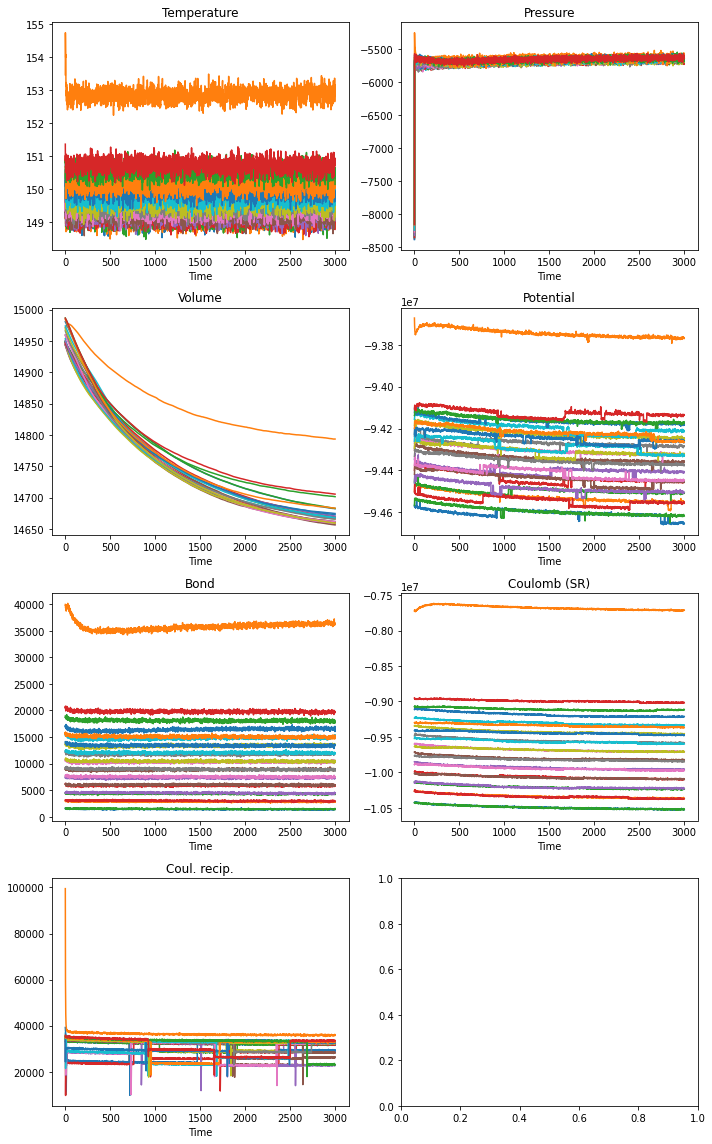

In [200]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Volume',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(parameter_keys):
    for y_quantity, position in zip(y_quantities, positions):
        # grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        grp.plot('Time', y_quantity, ax=ax[position], legend=False, title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [205]:
query = {
    'metadata.project': project_id,
    'metadata.step': {'$regex': 'GromacsRelaxation'},
    'metadata.type': 'mp4_file',
}

In [206]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

8

In [207]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())


In [208]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

........

In [209]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

('cylinders', 648)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01\t\xca\x88mdat\x00\…

('cylinders', 486)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01\xc6=|mdat\x00\x00\…

('cylinders', 567)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01\xcb\xdfBmdat\x00\x…

('cylinders', 243)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01o\xc0\xb8mdat\x00\x…

('bilayer', 567)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01\xe0\x1f\x95mdat\x0…

('bilayer', 324)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01\xd5]=mdat\x00\x00\…

('bilayer', 648)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x02\x06\xd1\xedmdat\x0…

('bilayer', 729)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x02\'\xf28mdat\x00\x00…


### Pre-evaluated RDF

#### Overview

In [210]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

72

In [211]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [212]:
res_df

type                    earliest  \
0  surfactant_tail_surfactant_tail_rdf  2020-10-13 23:31:57.921390   
1  surfactant_head_surfactant_tail_rdf  2020-10-13 23:31:57.921388   
2  surfactant_head_surfactant_head_rdf  2020-10-13 23:31:57.921386   
3        substrate_surfactant_tail_rdf  2020-10-13 23:31:57.921383   
4        substrate_surfactant_head_rdf  2020-10-13 23:31:57.921381   
5       counterion_surfactant_tail_rdf  2020-10-13 23:31:57.921379   
6       counterion_surfactant_head_rdf  2020-10-13 23:31:57.921376   
7             counterion_substrate_rdf  2020-10-13 23:31:57.921374   
8            counterion_counterion_rdf  2020-10-13 23:31:57.921372   

                       latest  object_count  
0  2020-10-13 23:31:58.157126             8  
1  2020-10-13 23:31:58.157124             8  
2  2020-10-13 23:31:58.157122             8  
3  2020-10-13 23:31:58.157120             8  
4  2020-10-13 23:31:58.157117             8  
5  2020-10-13 23:31:58.157115             8  
6  2020-10-13 23:31:58.157113             8  
7  2020-10-13 23:31:58.157111             8  
8  2020-10-13 23:31:58.157108             8

#### Substrate - surfactant head RDF

In [219]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

8

In [220]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

In [221]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

........


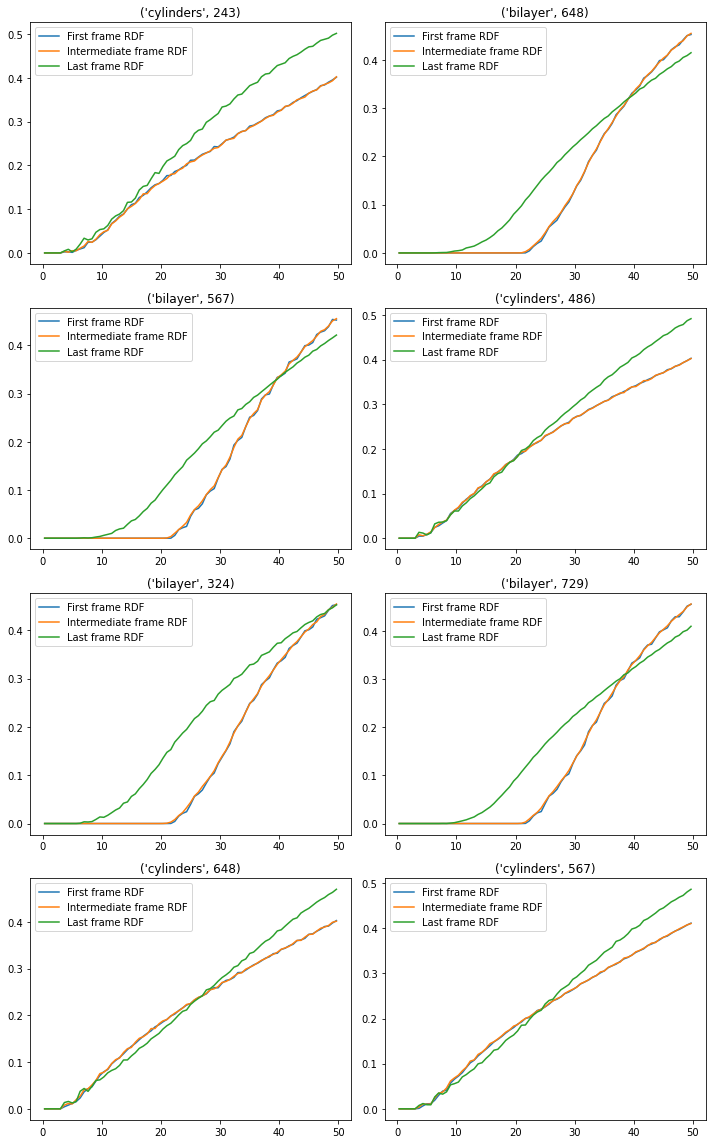

In [222]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Substrate - surfactant tail RDF

In [223]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

8

In [224]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

........


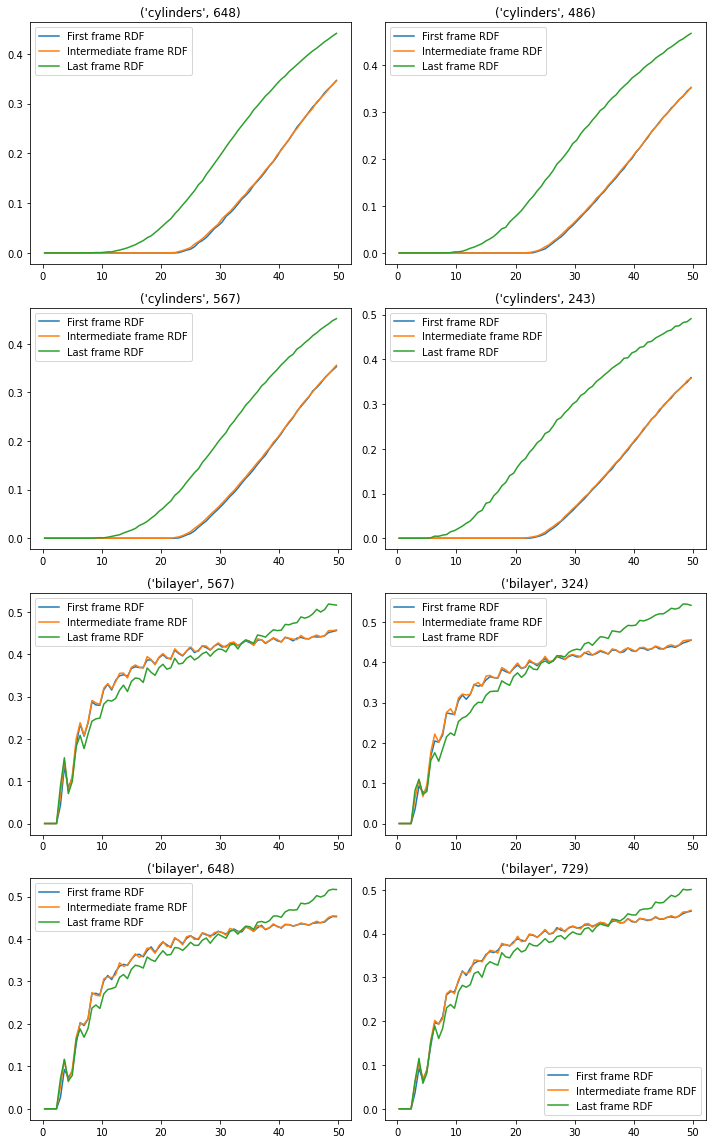

In [225]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
    
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant head - surfactant tail RDF

In [226]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

8

In [227]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.{}".format(parameter_keys[0]): pymongo.DESCENDING,
    }
}

aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

........


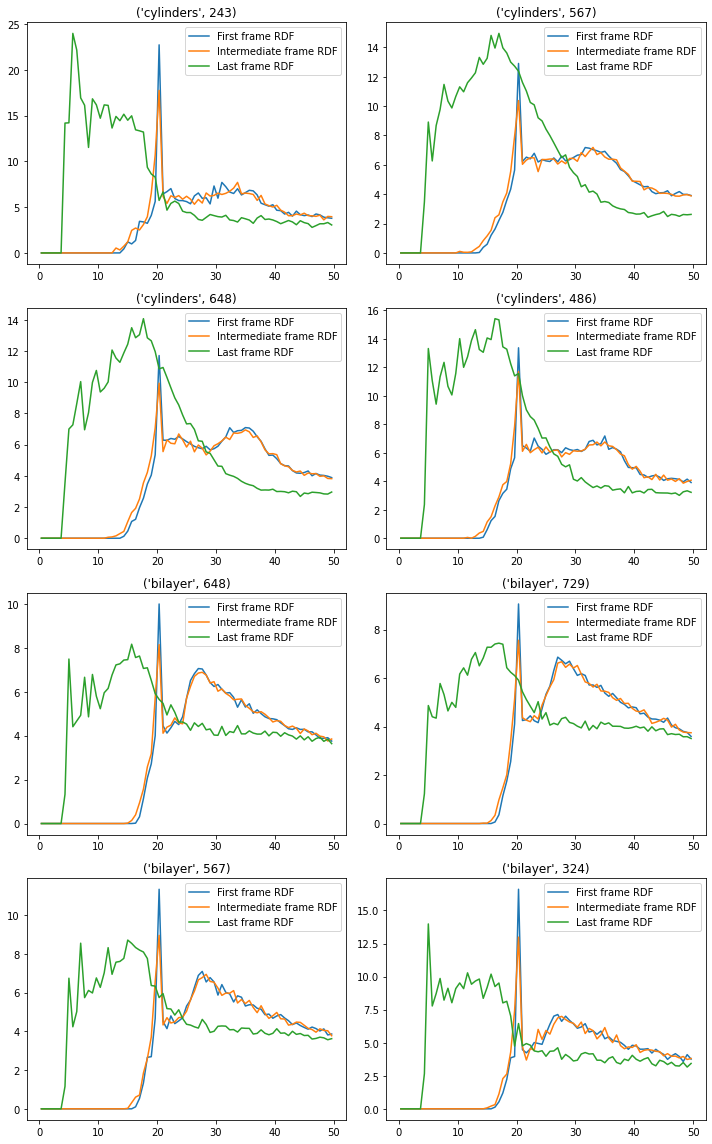

In [228]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant head - surfactant head RDF

In [232]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_head_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

8

In [233]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

In [234]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

........


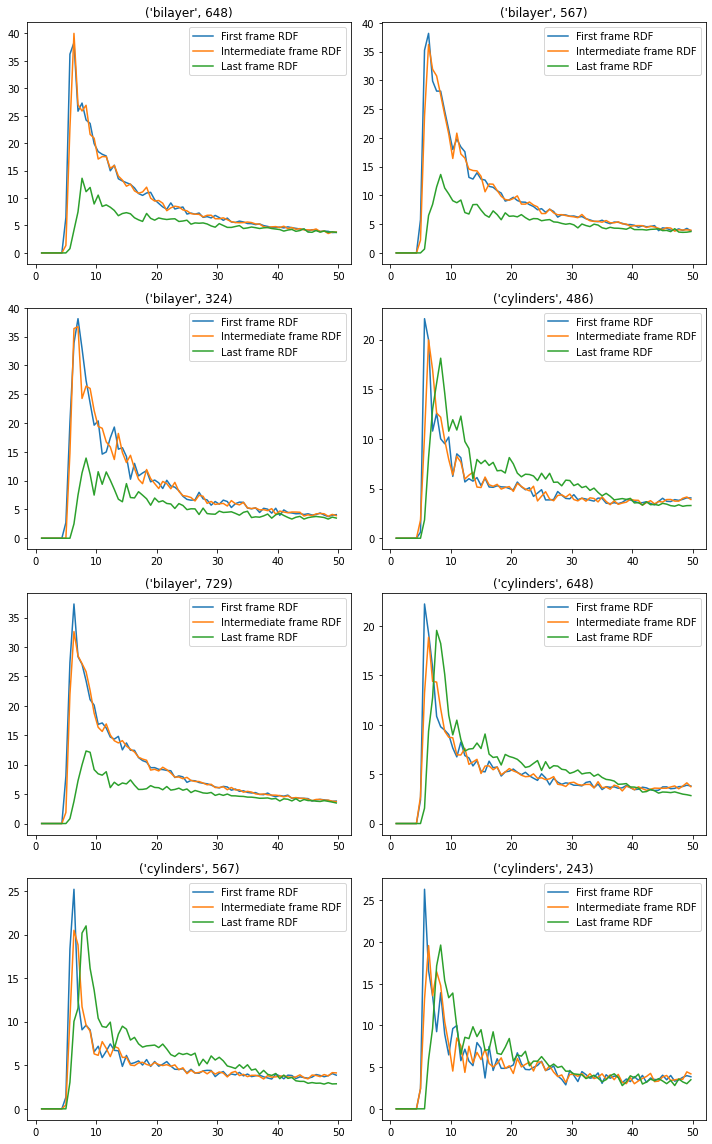

In [235]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][1:],data['rdf'][0][1:], label='First frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][len(data)//2][1:],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][-1][1:],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

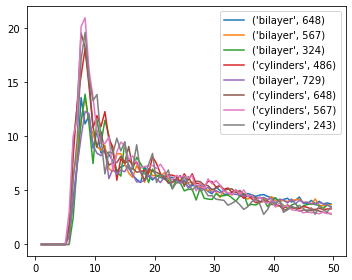

In [236]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'][1:],data['rdf'][-1][1:],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant tail - surfactant tail RDF

In [241]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_tail_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

8

In [242]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

In [243]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

........


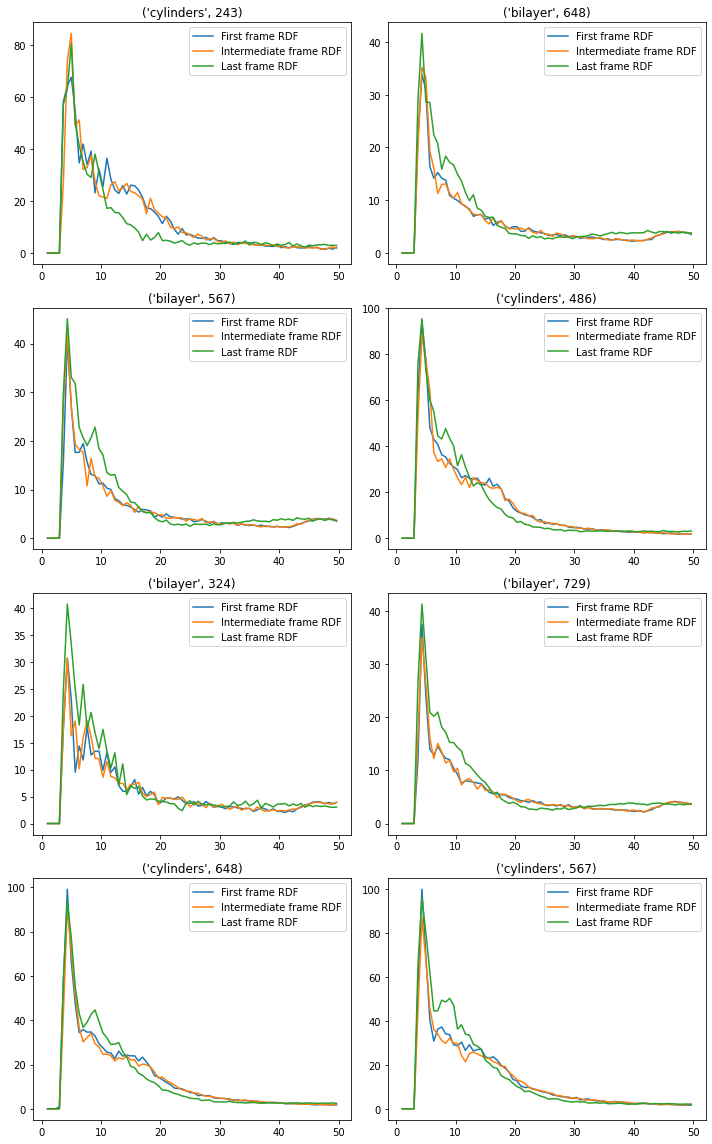

In [244]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][1:],data['rdf'][0][1:], label='First frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][len(data)//2][1:],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][-1][1:],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

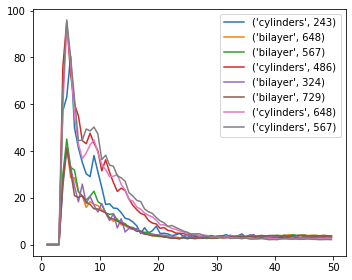

In [245]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'][1:],data['rdf'][-1][1:],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Counterion - surfactant head RDF

In [249]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'counterion_surfactant_head_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

8

In [250]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

In [251]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

........


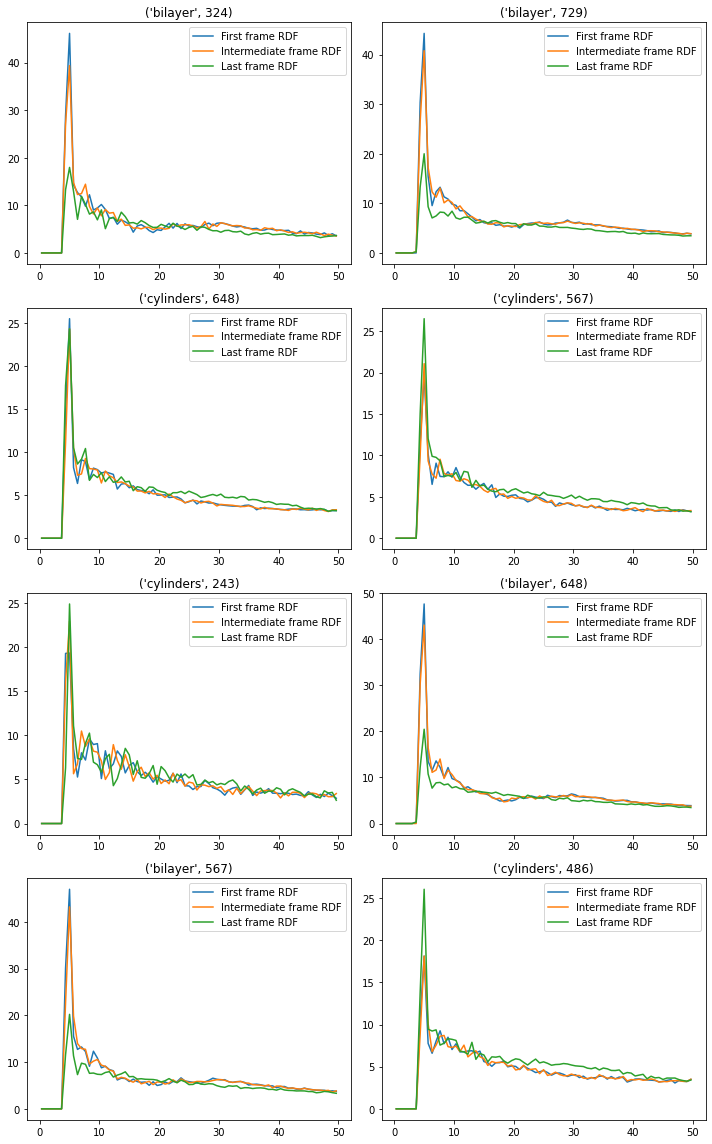

In [252]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

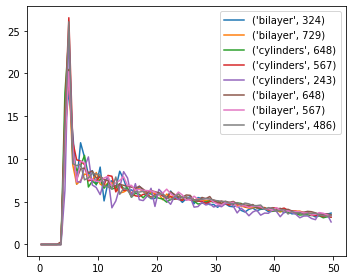

In [253]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'],data['rdf'][-1],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Counterion - surfactant tail RDF

In [254]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'counterion_surfactant_tail_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

8

In [255]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

In [256]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

........


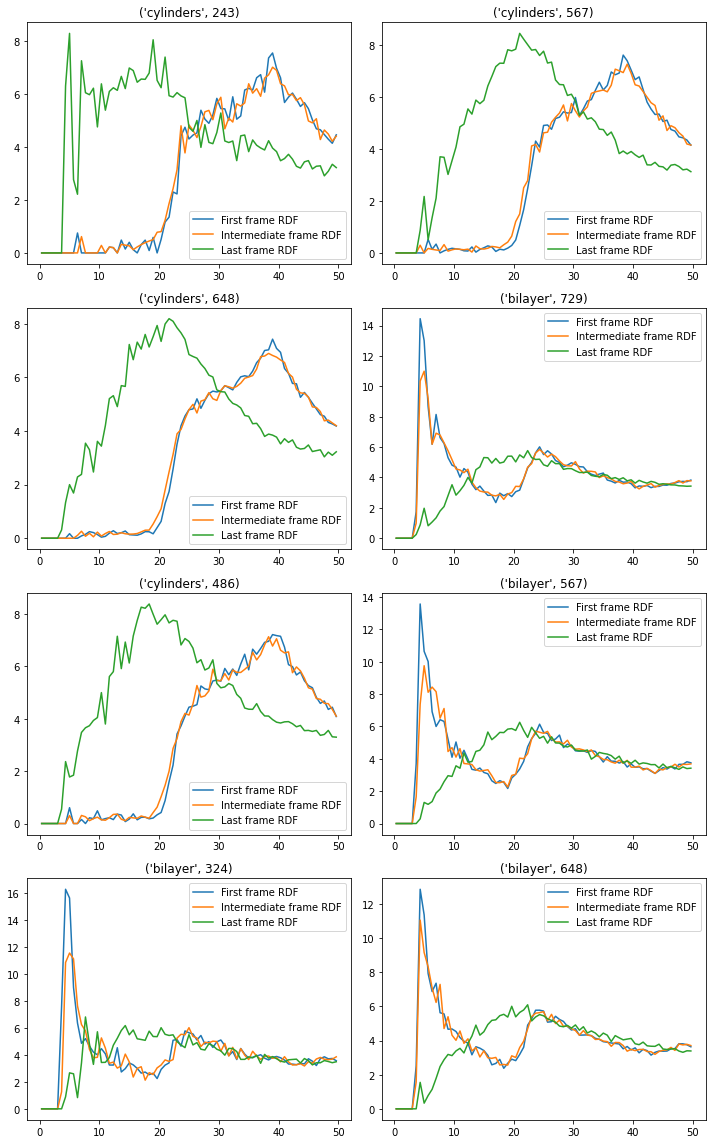

In [257]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

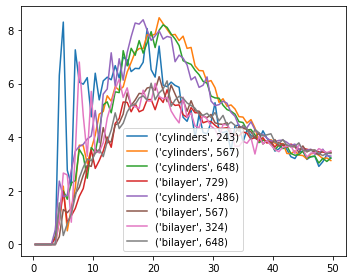

In [258]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'],data['rdf'][-1],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Counterion - substrate RDF

In [259]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'counterion_substrate_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

8

In [260]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

In [261]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

........


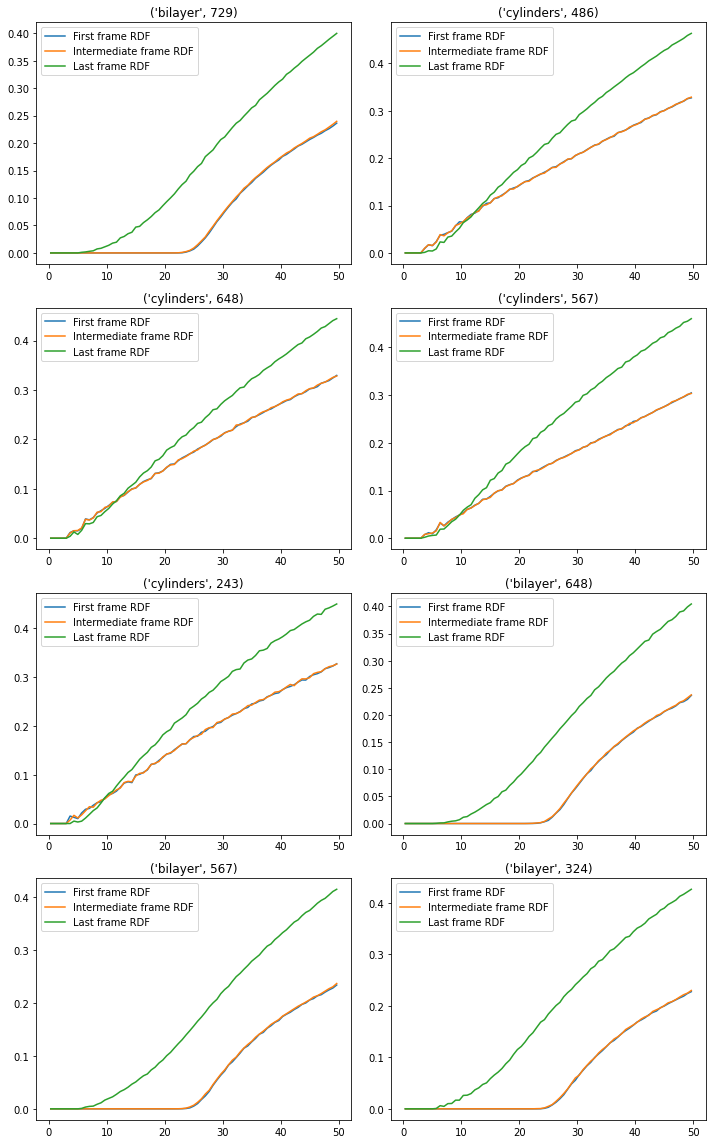

In [262]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

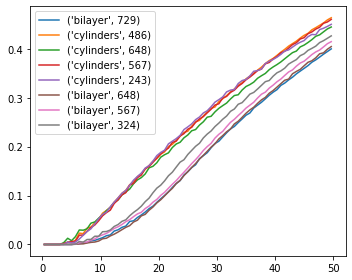

In [263]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'],data['rdf'][-1],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Counterion - counterion RDF

In [269]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'counterion_counterion_rdf',
    "metadata.step": {'$regex': "GromacsRelaxation"},
}

fp.filepad.count_documents(query)

8

In [270]:
parameter_dict = {
    'shape': 'metadata.system.surfactant.aggregates.shape',
    'nmolecules': 'metadata.system.surfactant.nmolecules'
}
parameter_keys = list(parameter_dict.keys())

In [271]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    parameter_values = tuple(c["_id"][parameter_key] for parameter_key in parameter_keys)
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[parameter_values] = {'dist': d, 'rdf': rdf}
    print('.',end='')
print('')

........


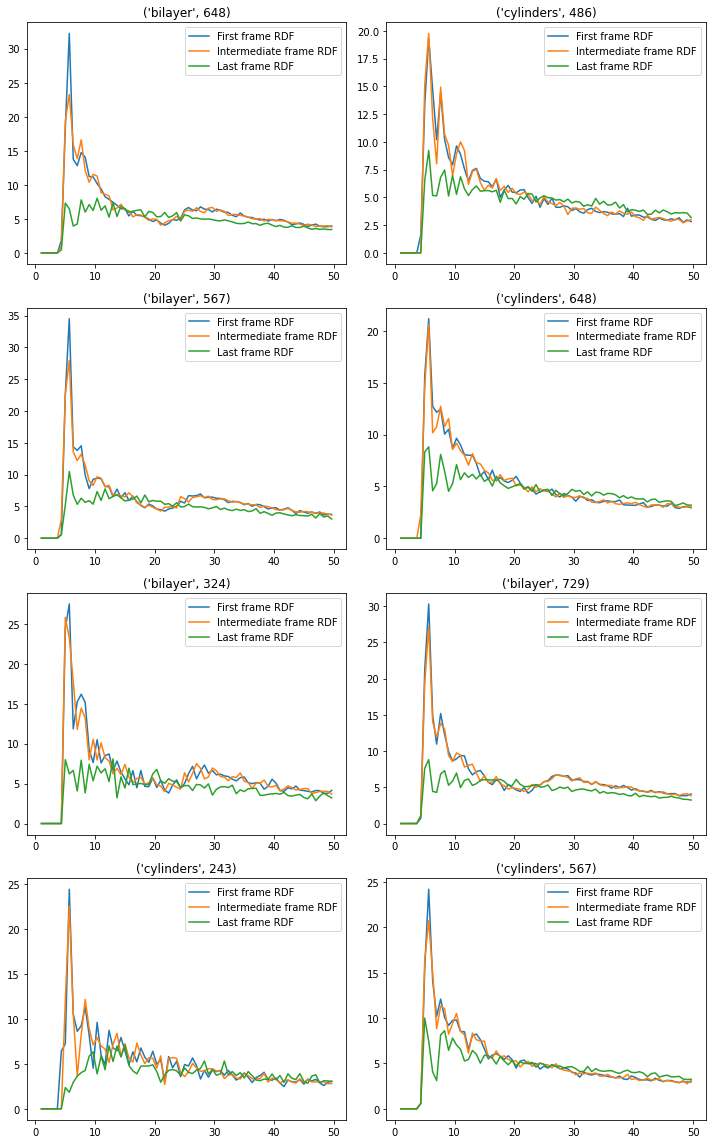

In [272]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['parameter_key']):
for pos, (parameter_key, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][1:],data['rdf'][0][1:], label='First frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][len(data)//2][1:],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][1:],data['rdf'][-1][1:],label='Last frame RDF')
    ax[pos].set_title(parameter_key)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

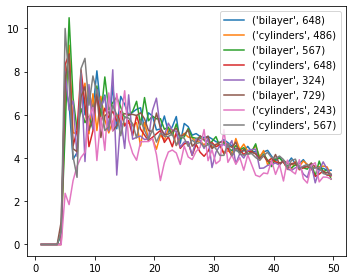

In [273]:
n = 1
cols = 2 if n > 1 else 1
rows = round(n/cols)

fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for (parameter_key, data) in res_dict.items():
    ax.plot(data['dist'][1:],data['rdf'][-1][1:],label=parameter_key)
    ax.legend()

fig.tight_layout()
# fig.legend()
fig.show()